In [1]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from torch import nn
import torch

from sklearn.metrics import mean_squared_error

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from processing.DataPreprocessor import DataPreprocessor
    from reservoir.BasicESNCudaVariableReadout import BasicESNCudaVariableReadout as BasicESN
    from reservoir.HierarchyESNCudaVariableReadout import HierarchyESNCudaVariableReadout as HierarchyESN
    from reservoir.ThreeHierarchyESNCudaVariableReadout import ThreeHierarchyESNCudaVariableReadout as ThreeHierarchyESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from datasetpreparation.datasetpreparation import DatasetPreparation
    from datapreprocessor.datapreprocessor import DataPreprocessor
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)

X_train, y_train = data_preparation.get_raw_data('train')
X_val, y_val = data_preparation.get_raw_data('val')
X_test, y_test = data_preparation.get_raw_data('test')

X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

class_weights = data_preparation.get_class_weights()

data_preprocessor = DataPreprocessor()

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646,)
X_val shape: (339404, 6), Y_val shape: (339404,)
X_test shape: (562547, 6), Y_test shape: (562547,)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled shape

In [6]:
# The data preprocessor object provides access to different data preprocessing methods
# The available methods are:
# - buffered_windows(window_size, x, y)
# - exponential_moving_average(alpha, x, y)
# - fourier_smoothing(x, threshold)
# - spectrogram_data(x, y, n_fft, stride, reshape)
# - spectrogram_predictions_to_samples(y_pred, n_samples, n_fft, stride)
# - pipeline(step_names, x, y)
# - get_available_steps()

# First, we will try a basicESN with the optimal hyperparameters found in the previous notebook along with the spectrogram_data preprocessing method

# The optimal hyperparameters were:
basic_n_neurons = 500
basic_density = 0.2
basic_leakage = 0.8
basic_spectral_radius = 0.999
basic_gamma = 0.999
basic_sparsity = 0.8
basic_input_weight_type = 'uniform'


In [7]:
epochs = 100
batch_size = 100

In [8]:
def fit_basic_model(readout, pickle_name, model_flag):
    if model_flag or not os.path.exists(pickle_name):

        input_weights = generate_input_weights(basic_n_neurons, X_train_scaled.shape[1], basic_density,
                                               basic_input_weight_type,
                                               seed=42)
    
        basic_esn = BasicESN(n_neurons=basic_n_neurons, leakage_rate=basic_leakage, spectral_radius=basic_spectral_radius,
                             gamma=basic_gamma,
                             sparsity=basic_sparsity, W_in=input_weights, class_weights=class_weights, seed=42)
    
        basic_esn.set_readout_model(readout)
    
        basic_esn.fit(X_train_scaled, y_train_encoded, x_val=X_val_scaled, y_val=y_val_encoded, epochs=epochs, batch_size=batch_size)
    
        with open(pickle_name, 'wb') as f:
            pickle.dump(basic_esn, f)
    
    else:
        with open(pickle_name, 'rb') as f:
            basic_esn = pickle.load(f)
            
    return basic_esn

def test_model(model, name):
    y_pred = model.forward(X_test_scaled)

    # Bring the data back to the cpu
    y_pred = y_pred.cpu().detach().numpy()
    
    # Before we can score the model, we need to decode the one-hot encoded labels
    # As we are using the spectrogram_data method, we need to convert the time frames back to samples
    
    
    y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)
    y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)
    
    # Calculate the NMRSE score
    nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_test_decoded.max() - y_test_decoded.min())
    
    print(f"{name} NRMSE: {nrmse}")
    
    # Create a classification report
    from sklearn.metrics import classification_report
    
    print(classification_report(y_test_decoded, y_pred_decoded))
    
    # Print the confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']
    
    conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Now a normalised confusion matrix
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalised Confusion Matrix')
    plt.show()
    
    losses, val_losses = model.get_losses()
    # Print the losses and validation losses on the same plot
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return nrmse, losses, val_losses

In [9]:
run_basic_LS = False

100%|██████████| 562547/562547 [02:42<00:00, 3457.68it/s]


Shape of previous_states: torch.Size([562547, 500])
Basic ESN LS NRMSE: 0.6464370339301391


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    346581
           3       0.01      0.03      0.02     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.09      1.00      0.16     43204
           8       0.00      0.00      0.00      8248

    accuracy                           0.08    562547
   macro avg       0.01      0.15      0.02    562547
weighted avg       0.01      0.08      0.01    562547



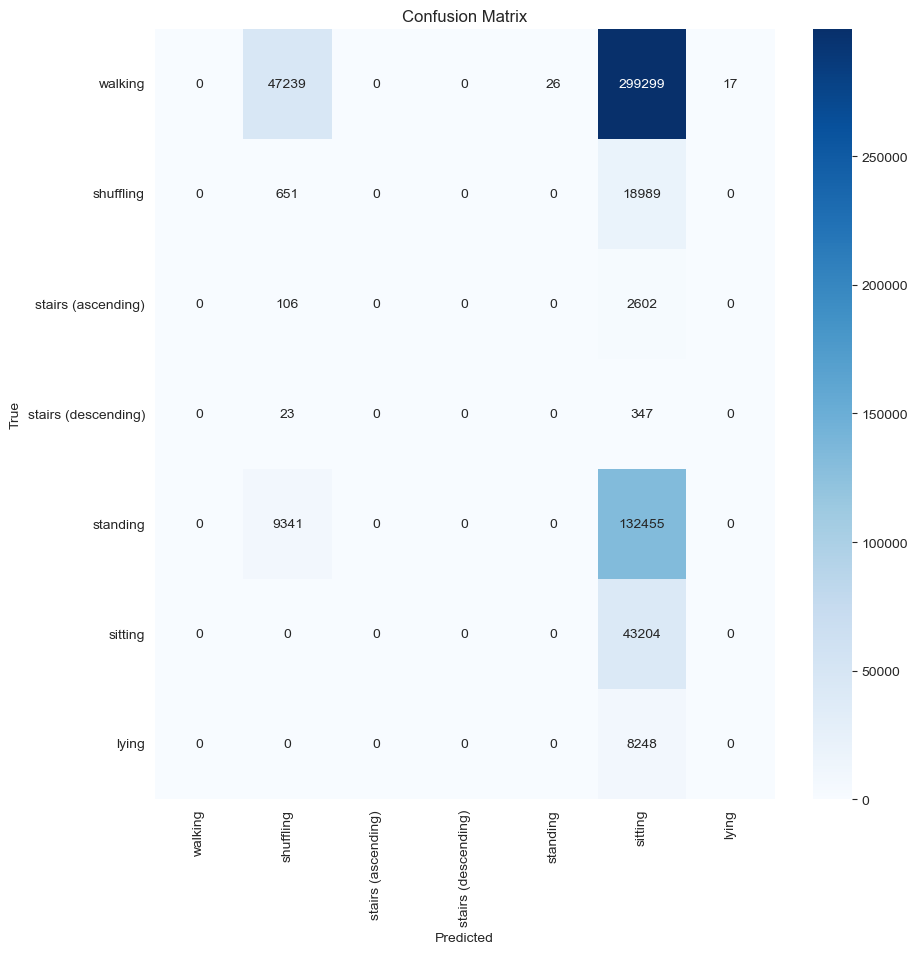

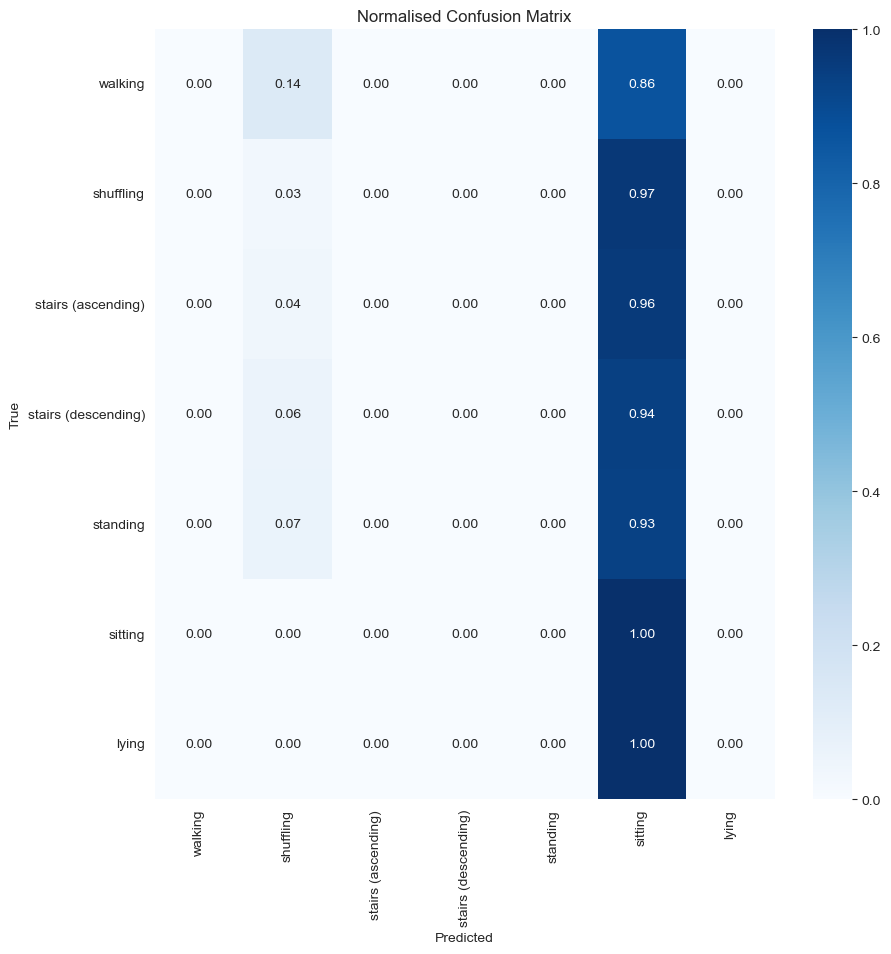

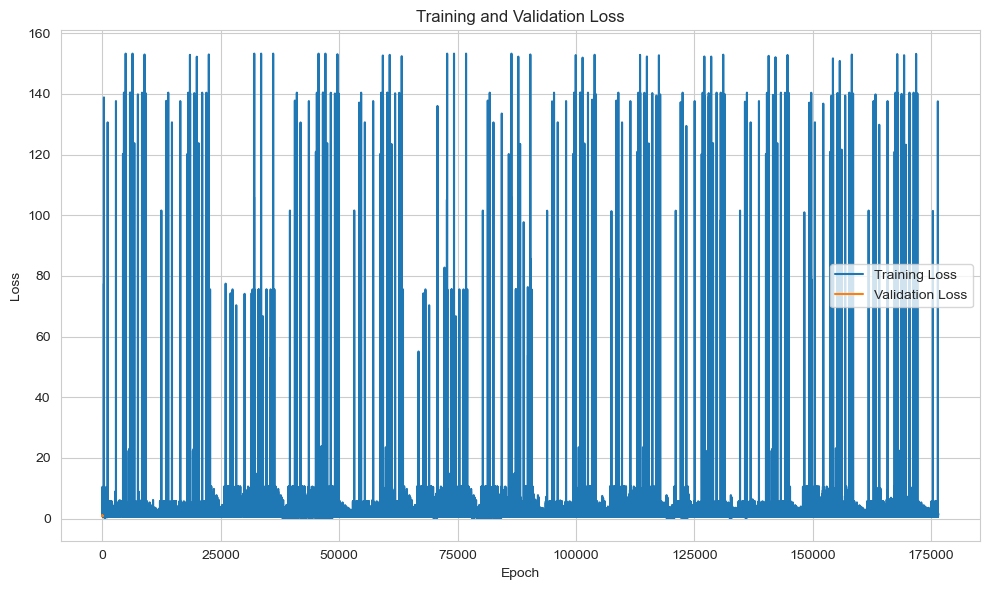

In [10]:
# Now we can try the best of each model and evaluate them on the test set
# We will use the best n_fft and stride values found for each model
basicESN_ls_pickle = 'basicESN_har70_variableReadout_ls.pkl'

# First, the basicESN with a readout of Linear -> Softmax

ls_readout = nn.Sequential(
    nn.Linear(basic_n_neurons, y_train_encoded.shape[1], device='cuda'),
    nn.Softmax(dim=1)
)

basic_esn = fit_basic_model(ls_readout, basicESN_ls_pickle, run_basic_LS)

nrmse_basic_ls, losses_ls, val_losses_ls = test_model(basic_esn, 'Basic ESN LS')

In [11]:
run_basic_LAS = False

100%|██████████| 562547/562547 [02:42<00:00, 3463.37it/s]


Shape of previous_states: torch.Size([562547, 500])
Basic ESN LAS NRMSE: 0.45126294012411183


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.62      1.00      0.76    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.00      0.00      0.00     43204
           8       0.00      0.00      0.00      8248

    accuracy                           0.62    562547
   macro avg       0.09      0.14      0.11    562547
weighted avg       0.38      0.62      0.47    562547



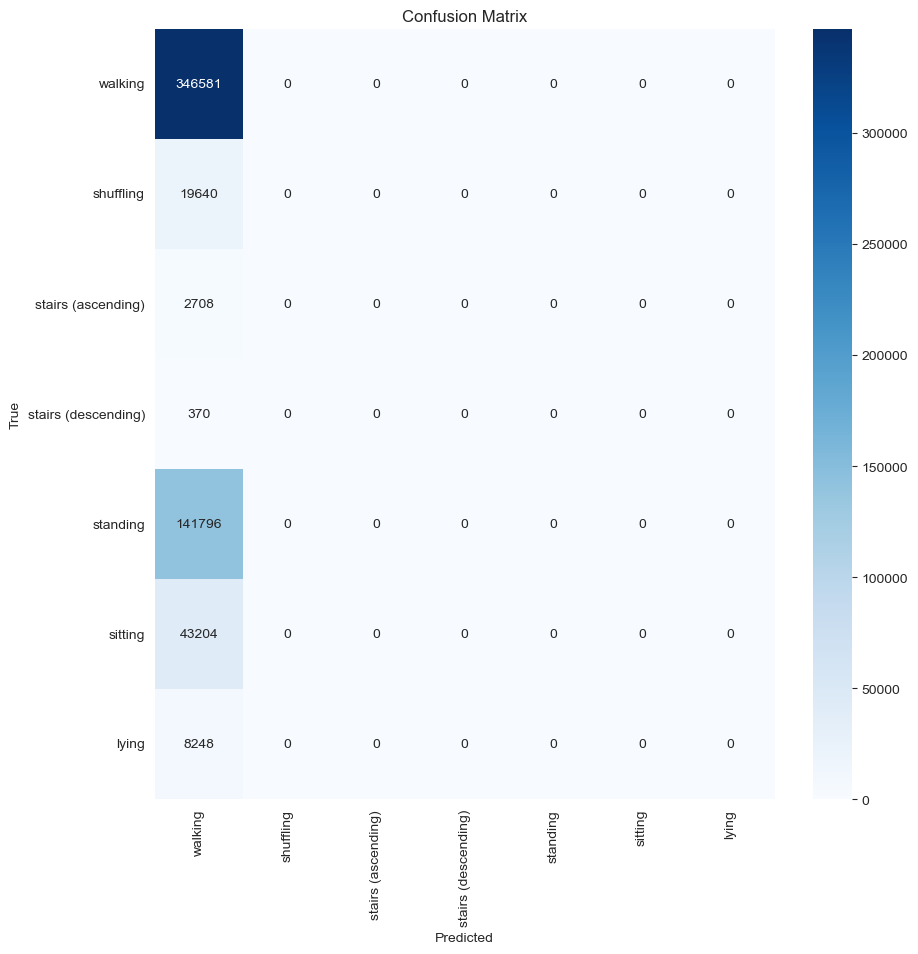

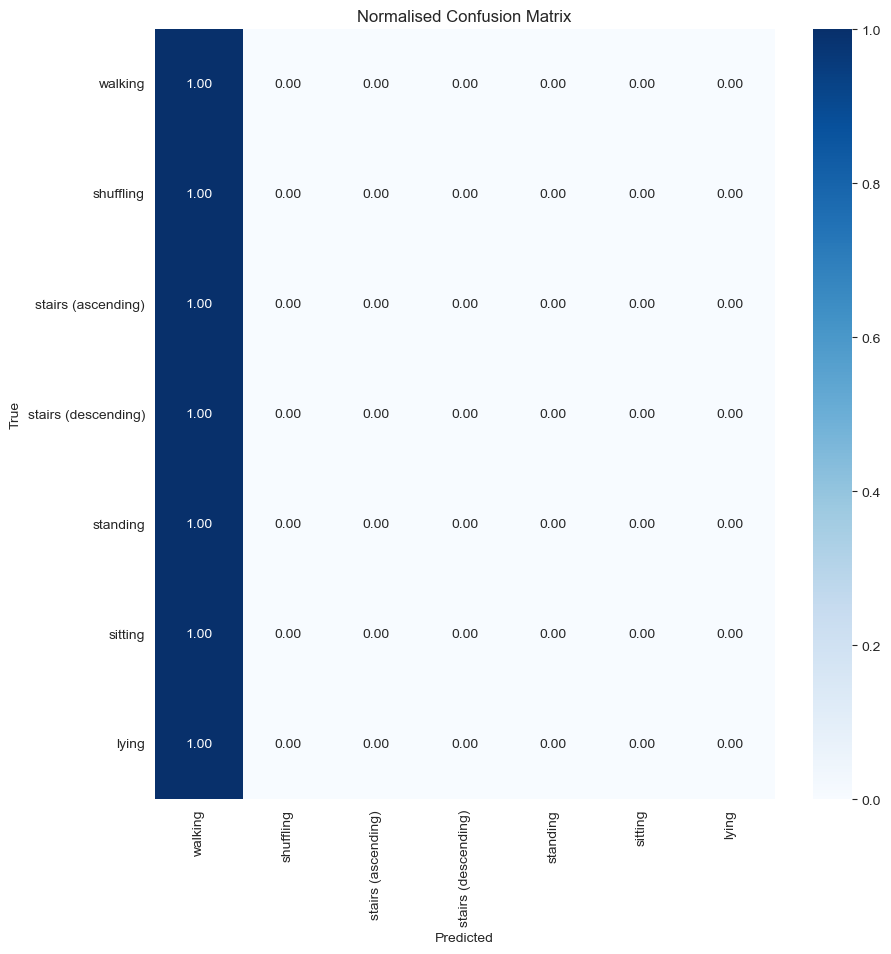

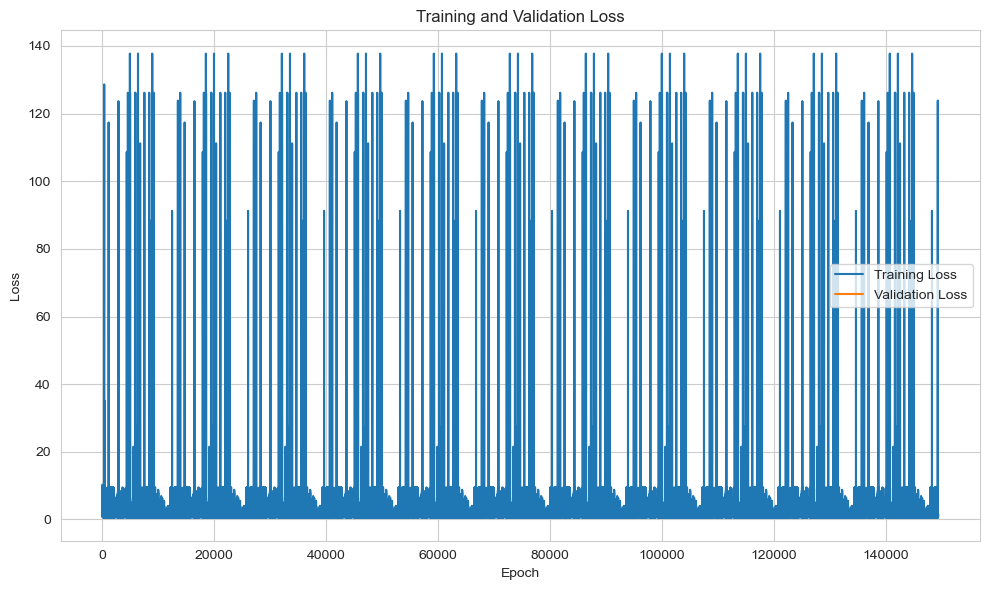

In [12]:
# Now we will try the basicESN with a readout of Linear -> Activation -> Softmax

basicESN_las_pickle = 'basicESN_har70_variableReadout_las.pkl'

las_readout = nn.Sequential(
    nn.Linear(basic_n_neurons, y_train_encoded.shape[1], device='cuda'),
    nn.ReLU(),
    nn.Softmax(dim=1)
)

basic_esn = fit_basic_model(las_readout, basicESN_las_pickle, run_basic_LAS)
        
nrmse_basic_las, losses_las, val_losses_las = test_model(basic_esn, 'Basic ESN LAS')


In [13]:
# Now we will try the basicESN with a readout of Linear -> Activation -> Linear -> Softmax

run_basic_LALS = False

100%|██████████| 562547/562547 [02:42<00:00, 3463.16it/s]


Shape of previous_states: torch.Size([562547, 500])
Basic ESN LALS NRMSE: 0.3182667755623841


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    346581
           3       0.04      0.96      0.07     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.61      0.11      0.18    141796
           7       0.81      1.00      0.89     43204
           8       0.00      0.00      0.00      8248

    accuracy                           0.14    562547
   macro avg       0.21      0.30      0.16    562547
weighted avg       0.22      0.14      0.12    562547



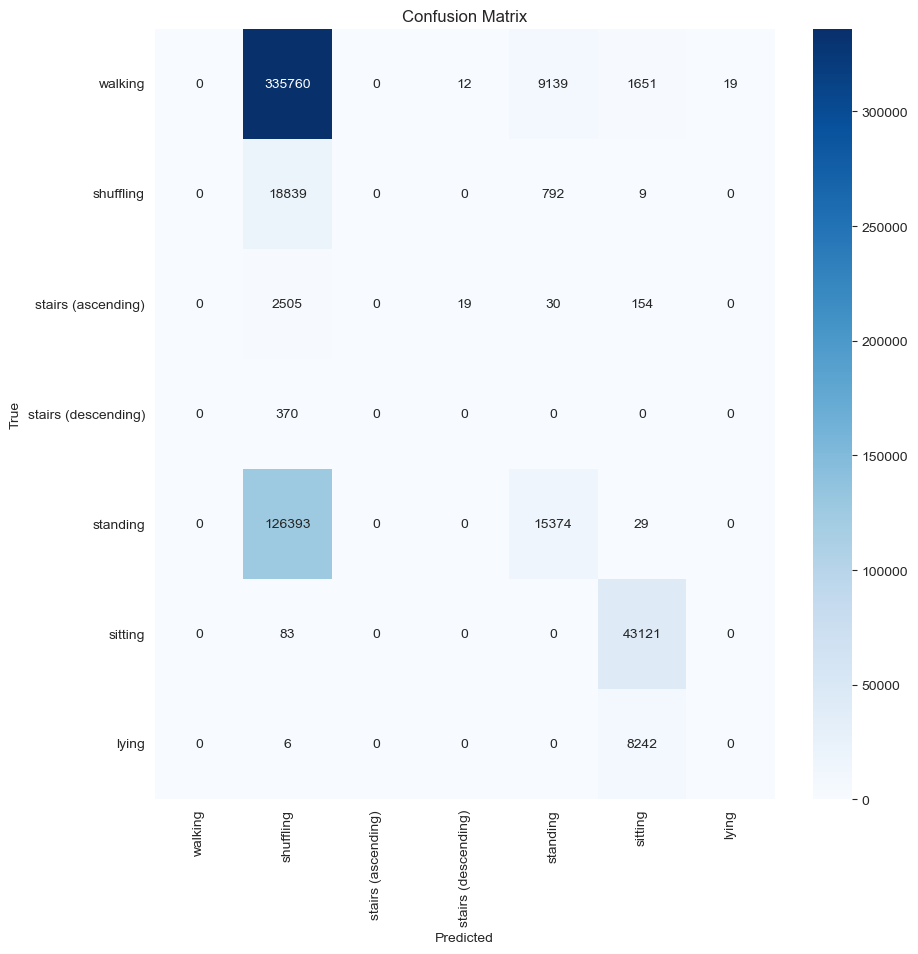

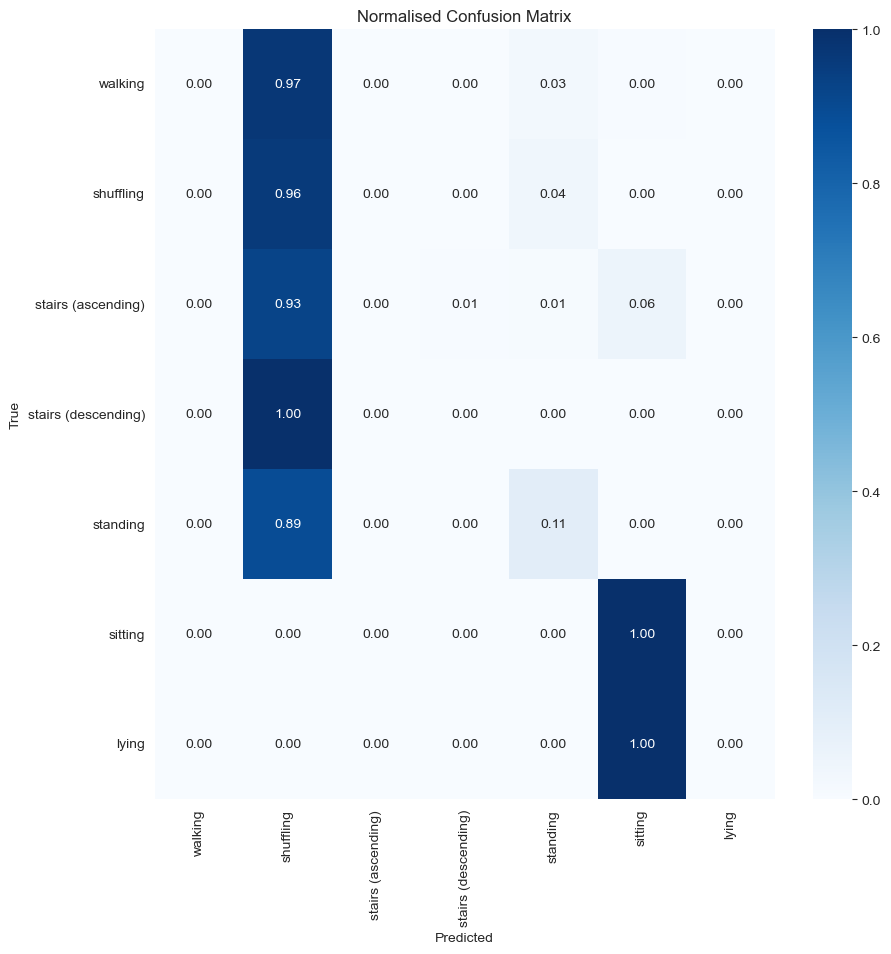

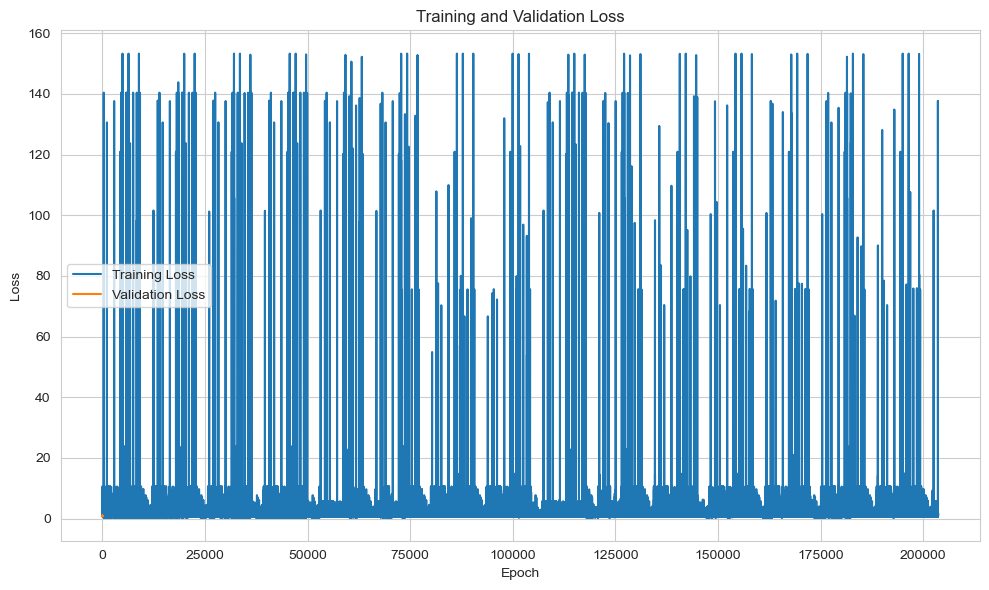

In [14]:
basicESN_lals_pickle = 'basicESN_har70_variableReadout_lals.pkl'

n_neurons_output_midpoint = (basic_n_neurons + y_train_encoded.shape[1]) // 2
lals_readout = nn.Sequential(
    nn.Linear(basic_n_neurons, n_neurons_output_midpoint, device='cuda'),
    nn.ReLU(),
    nn.Linear(n_neurons_output_midpoint, y_train_encoded.shape[1], device='cuda'),
    nn.Softmax(dim=1)
)

basic_esn = fit_basic_model(lals_readout, basicESN_lals_pickle, run_basic_LALS)

nrmse_basic_lals, losses_lals, val_losses_lals = test_model(basic_esn, 'Basic ESN LALS')

In [15]:
# Now we will try the basicESN with a readout of Linear -> Activation -> Dropout -> Linear -> Softmax

run_basic_LADLS = False

100%|██████████| 562547/562547 [02:42<00:00, 3465.66it/s]


Shape of previous_states: torch.Size([562547, 500])
BasicESN LADLS NRMSE: 0.42704829876822187


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.71      0.38      0.49    346581
           3       0.04      0.13      0.06     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.32      0.00       370
           6       0.39      0.34      0.36    141796
           7       0.94      0.93      0.93     43204
           8       0.97      0.88      0.92      8248

    accuracy                           0.41    562547
   macro avg       0.44      0.42      0.40    562547
weighted avg       0.62      0.41      0.48    562547



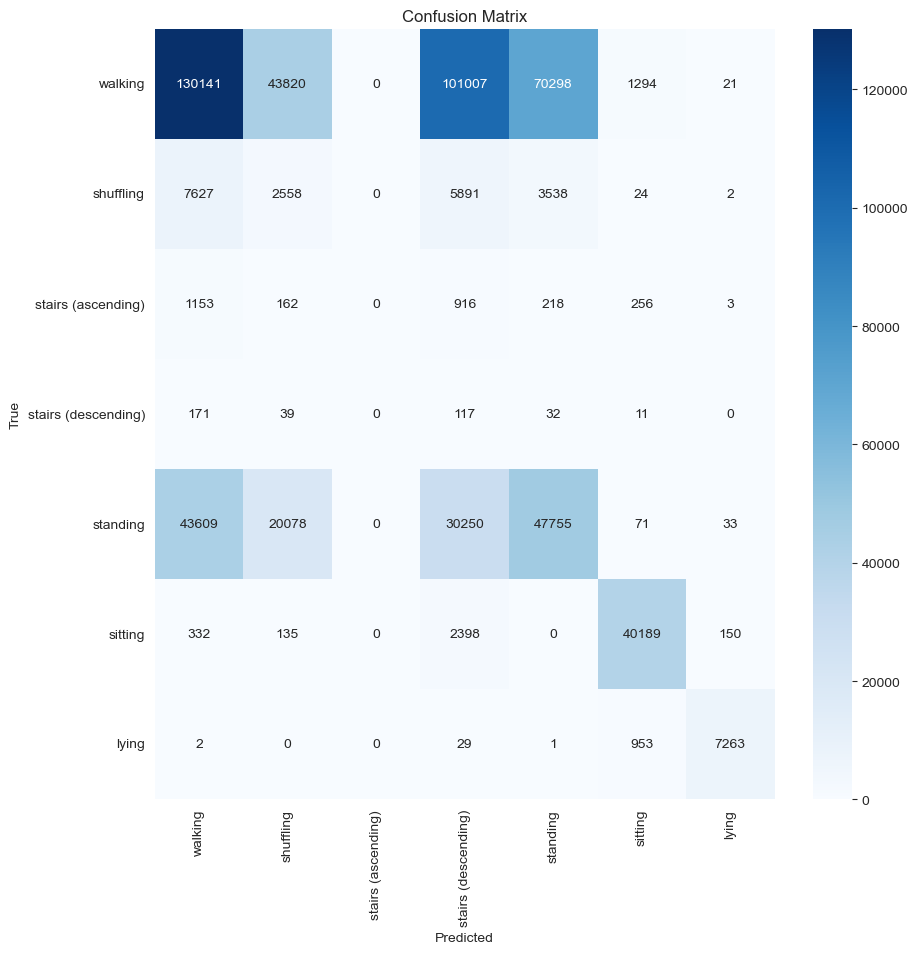

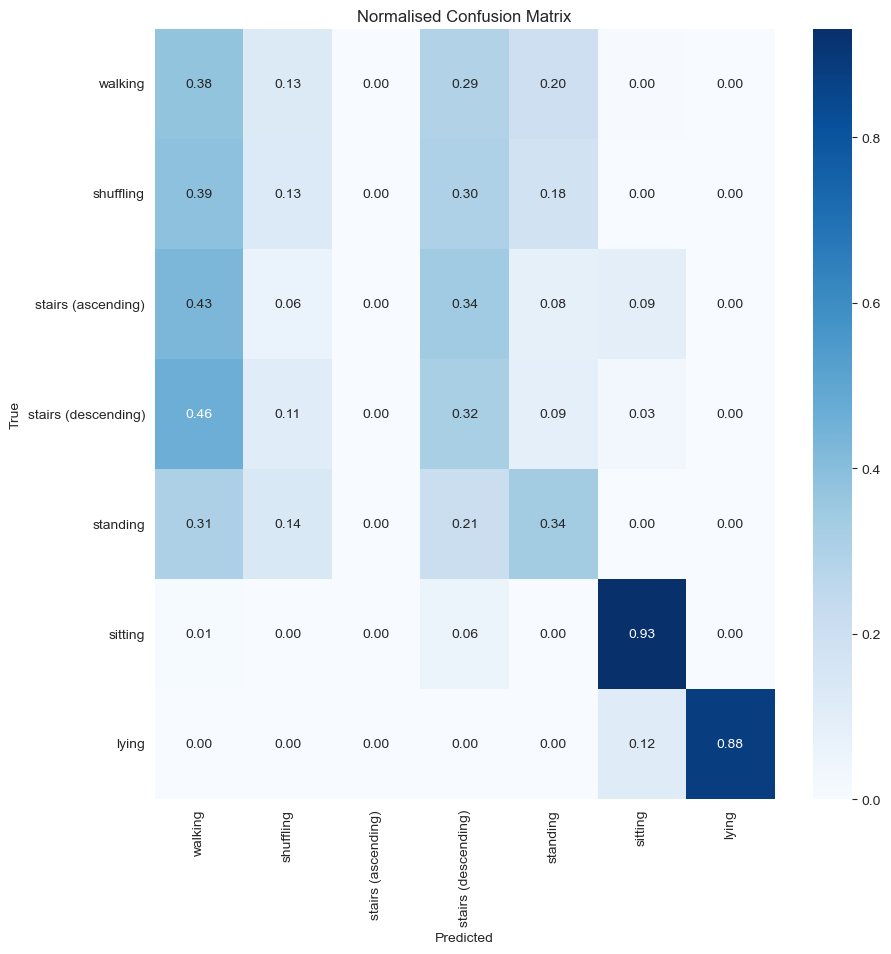

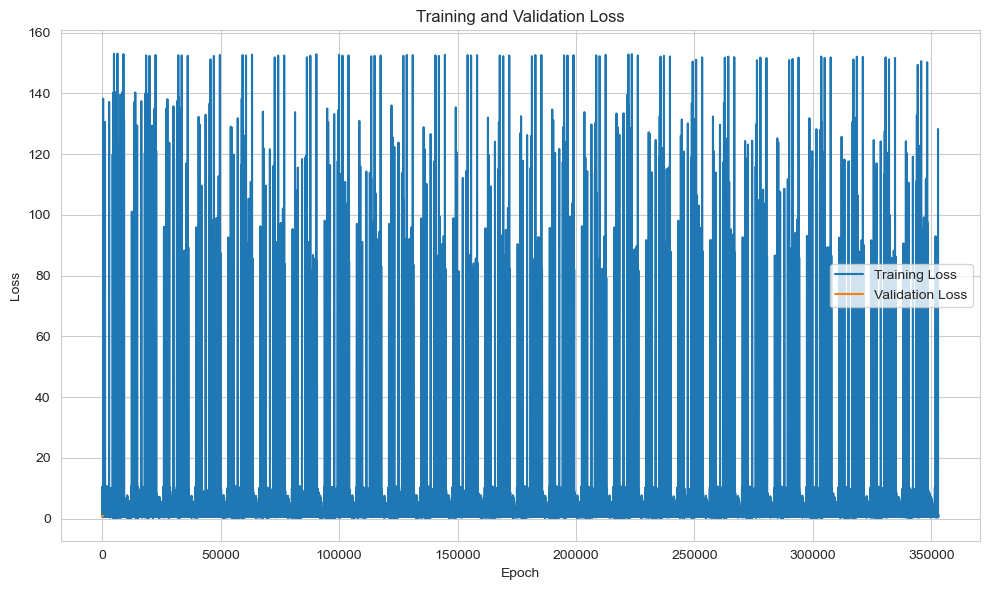

In [16]:
basicESN_laDls_pickle = 'basicESN_har70_variableReadout_ladls.pkl'

l_adls_readout = nn.Sequential(
    nn.Linear(basic_n_neurons, n_neurons_output_midpoint, device='cuda'),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(n_neurons_output_midpoint, y_train_encoded.shape[1], device='cuda'),
    nn.Softmax(dim=1)
)

basic_esn = fit_basic_model(l_adls_readout, basicESN_laDls_pickle, run_basic_LADLS)

nrmse_basic_ladls, losses_ladls, val_losses_ladls = test_model(basic_esn, 'BasicESN LADLS')

In [17]:
# Now we will do the same but for the hierarchyESN and threeHierarchyESN models

hierarchy_n_neurons_1 = 400
hierarchy_density_1 = 0.7983216917715843
hierarchy_leakage_1 = 0.9318915931720418
hierarchy_spectral_radius_1 = 0.9819903553570943
hierarchy_gamma_1 = 0.9634809164294149
hierarchy_sparsity_1 = 0.8
hierarchy_input_weight_type_1 = 'uniform'

hierarchy_n_neurons_2 = 100
hierarchy_density_2 = 0.010877135881297934
hierarchy_leakage_2 = 0.35101073644620073
hierarchy_spectral_radius_2 = 0.1404437385565157
hierarchy_gamma_2 = 0.7797466776214464
hierarchy_sparsity_2 = 0.5
hierarchy_input_weight_type_2 = 'uniform'

In [18]:

threeh_n_neurons_1 = 350
threeh_density_1 = 0.8098222387059135
threeh_leakage_1 = 0.9721196221438391
threeh_spectral_radius_1 = 0.9048794207552125
threeh_gamma_1 = 0.8008014185674769
threeh_sparsity_1 = 0.302371243155928
threeh_input_weight_type_1 = 'uniform'

threeh_n_neurons_2 = 33
threeh_density_2 = 0.750474862642194
threeh_leakage_2 = 0.5610244981317168
threeh_spectral_radius_2 = 0.0532568977054132
threeh_gamma_2 = 0.1906404433300536
threeh_sparsity_2 = 0.23013225478870247
threeh_input_weight_type_2 = 'uniform'

threeh_n_neurons_3 = 117
threeh_density_3 = 0.7438124394609645
threeh_leakage_3 = 0.6674647243532564
threeh_spectral_radius_3 = 0.13303480091978592
threeh_gamma_3 = 0.4754788170338825
threeh_sparsity_3 = 0.8292750282111857
threeh_input_weight_type_3 = 'uniform'

In [19]:
def fit_hierarchical_model(readout, pickle_name, model_flag):
    if model_flag or not os.path.exists(pickle_name):

        input_weights_1 = generate_input_weights(hierarchy_n_neurons_1, X_train_scaled.shape[1], hierarchy_density_1,
                                                    hierarchy_input_weight_type_1,
                                                    seed=42)
        
        input_weights_2 = generate_input_weights(hierarchy_n_neurons_2, X_train_scaled.shape[1], hierarchy_density_2,
                                                    hierarchy_input_weight_type_2,
                                                    seed=42)

        hierarchy_esn = HierarchyESN(n_neurons_1=hierarchy_n_neurons_1, n_neurons_2=hierarchy_n_neurons_2,
                                        leakage_rate_1=hierarchy_leakage_1, leakage_rate_2=hierarchy_leakage_2,
                                        spectral_radius_1=hierarchy_spectral_radius_1, spectral_radius_2=hierarchy_spectral_radius_2,
                                        gamma_1=hierarchy_gamma_1, gamma_2=hierarchy_gamma_2,
                                        sparsity_1=hierarchy_sparsity_1, sparsity_2=hierarchy_sparsity_2,
                                        W_in_1=input_weights_1, W_in_2=input_weights_2, class_weights=class_weights, seed=42)
        
        hierarchy_esn.set_readout_model(readout)

        hierarchy_esn.fit(X_train_scaled, y_train_encoded, x_val=X_val_scaled, y_val=y_val_encoded, epochs=epochs, batch_size=batch_size)

        with open(pickle_name, 'wb') as f:
            pickle.dump(hierarchy_esn, f)

    else:
        with open(pickle_name, 'rb') as f:
            hierarchy_esn = pickle.load(f)

    return hierarchy_esn

def fit_three_hierarchical_model(readout, pickle_name, model_flag):
    if model_flag or not os.path.exists(pickle_name):

        input_weights_1 = generate_input_weights(threeh_n_neurons_1, X_train_scaled.shape[1], threeh_density_1,
                                                    threeh_input_weight_type_1,
                                                    seed=42)

        input_weights_2 = generate_input_weights(threeh_n_neurons_2, X_train_scaled.shape[1], threeh_density_2,
                                                    threeh_input_weight_type_2,
                                                    seed=42)

        input_weights_3 = generate_input_weights(threeh_n_neurons_3, X_train_scaled.shape[1], threeh_density_3,
                                                    threeh_input_weight_type_3,
                                                    seed=42)

        three_hierarchy_esn = ThreeHierarchyESN(n_neurons_1=threeh_n_neurons_1, n_neurons_2=threeh_n_neurons_2,
                                                n_neurons_3=threeh_n_neurons_3,
                                                leakage_rate_1=threeh_leakage_1, leakage_rate_2=threeh_leakage_2,
                                                leakage_rate_3=threeh_leakage_3,
                                                spectral_radius_1=threeh_spectral_radius_1, spectral_radius_2=threeh_spectral_radius_2,
                                                spectral_radius_3=threeh_spectral_radius_3,
                                                gamma_1=threeh_gamma_1, gamma_2=threeh_gamma_2, gamma_3=threeh_gamma_3,
                                                sparsity_1=threeh_sparsity_1, sparsity_2=threeh_sparsity_2, sparsity_3=threeh_sparsity_3,
                                                W_in_1=input_weights_1, W_in_2=input_weights_2, W_in_3=input_weights_3, class_weights=class_weights, seed=42)

        three_hierarchy_esn.set_readout_model(readout)

        three_hierarchy_esn.fit(X_train_scaled, y_train_encoded, x_val=X_val_scaled, y_val=y_val_encoded, epochs=epochs, batch_size=batch_size)

        with open(pickle_name, 'wb') as f:
            pickle.dump(three_hierarchy_esn, f)

    else:
        with open(pickle_name, 'rb') as f:
            three_hierarchy_esn = pickle.load(f)

    return three_hierarchy_esn

In [20]:
# First, the hierarchyESN with a readout of Linear -> Softmax

run_hierarchy_LS = False

100%|██████████| 562547/562547 [05:52<00:00, 1595.43it/s]


Shape of previous_states: torch.Size([562547, 500])
Hierarchy ESN LS NRMSE: 0.6614365028572128


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    346581
           3       0.03      0.11      0.04     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       1.00      0.04      0.08    141796
           7       0.09      1.00      0.17     43204
           8       0.38      0.01      0.01      8248

    accuracy                           0.09    562547
   macro avg       0.21      0.17      0.04    562547
weighted avg       0.27      0.09      0.04    562547



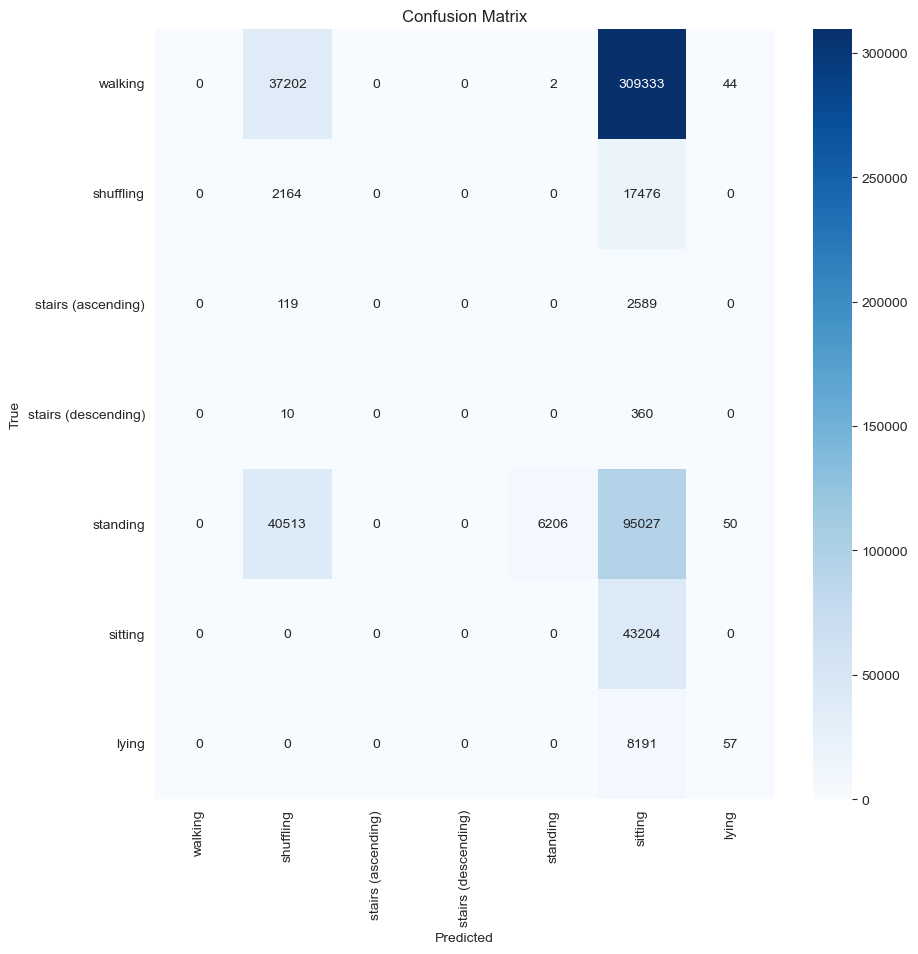

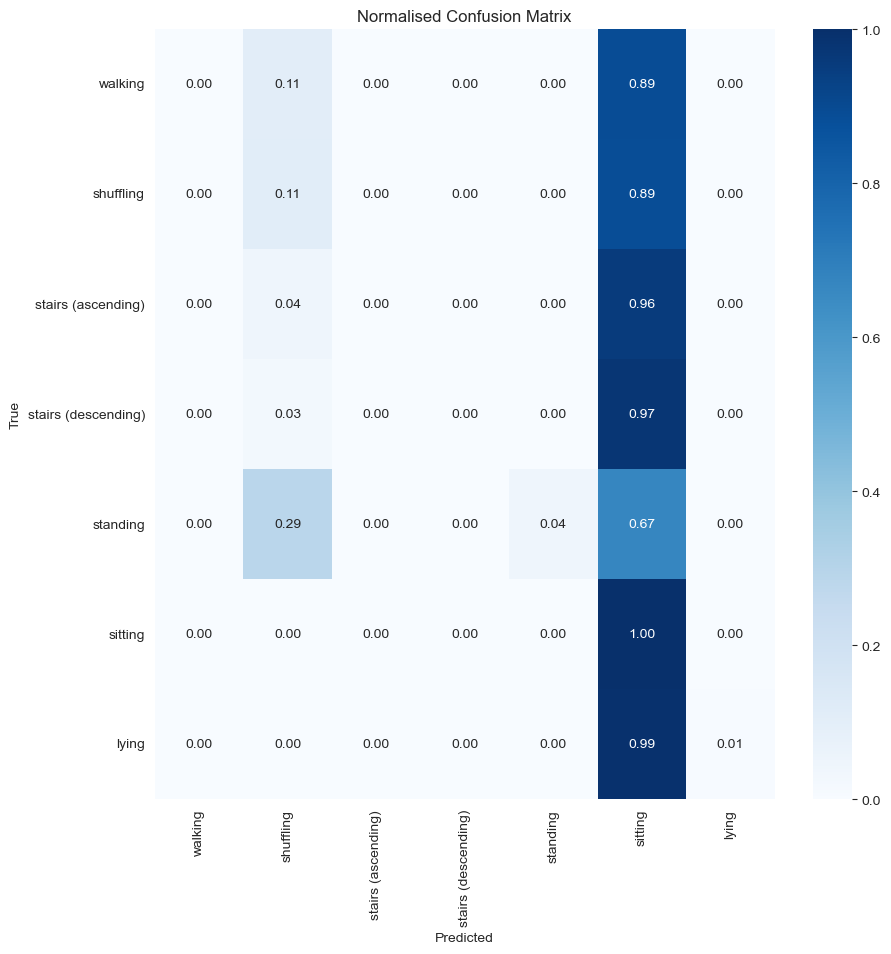

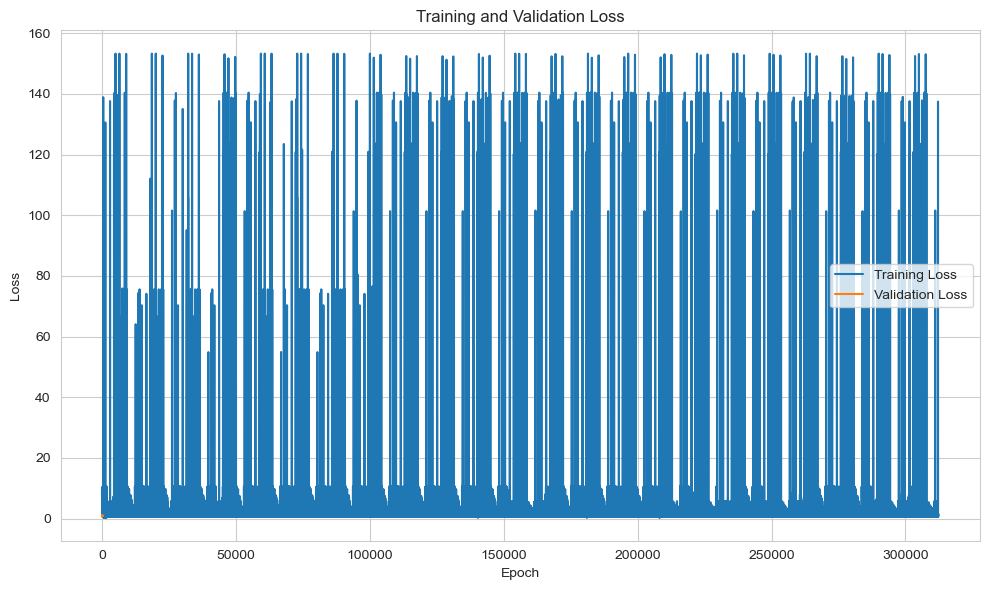

In [21]:
# The optimal hyperparameters were:
hierarchyESN_ls_pickle = 'hierarchyESN_har70_variableReadout_ls.pkl'

ls_readout = nn.Sequential(
    nn.Linear(hierarchy_n_neurons_2 + hierarchy_n_neurons_1, y_train_encoded.shape[1], device='cuda'),
    nn.Softmax(dim=1)
)

hierarchy_esn = fit_hierarchical_model(ls_readout, hierarchyESN_ls_pickle, run_hierarchy_LS)

nrmse_hierarchy_ls, losses_hierarchy_ls, val_losses_hierarchy_ls = test_model(hierarchy_esn, 'Hierarchy ESN LS')
    

In [22]:
run_hierarchy_LAS = False

100%|██████████| 562547/562547 [05:51<00:00, 1600.60it/s]


Shape of previous_states: torch.Size([562547, 500])
Hierarchy ESN LAS NRMSE: 0.45126294012411183


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.62      1.00      0.76    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.00      0.00      0.00     43204
           8       0.00      0.00      0.00      8248

    accuracy                           0.62    562547
   macro avg       0.09      0.14      0.11    562547
weighted avg       0.38      0.62      0.47    562547



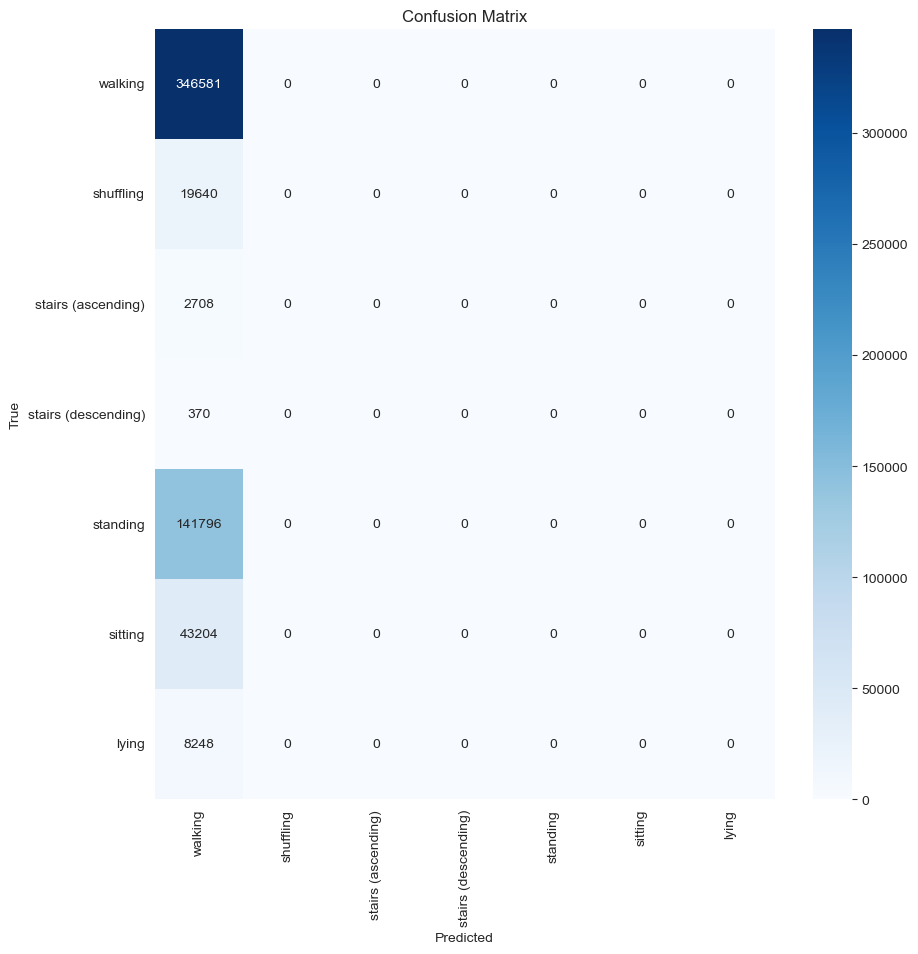

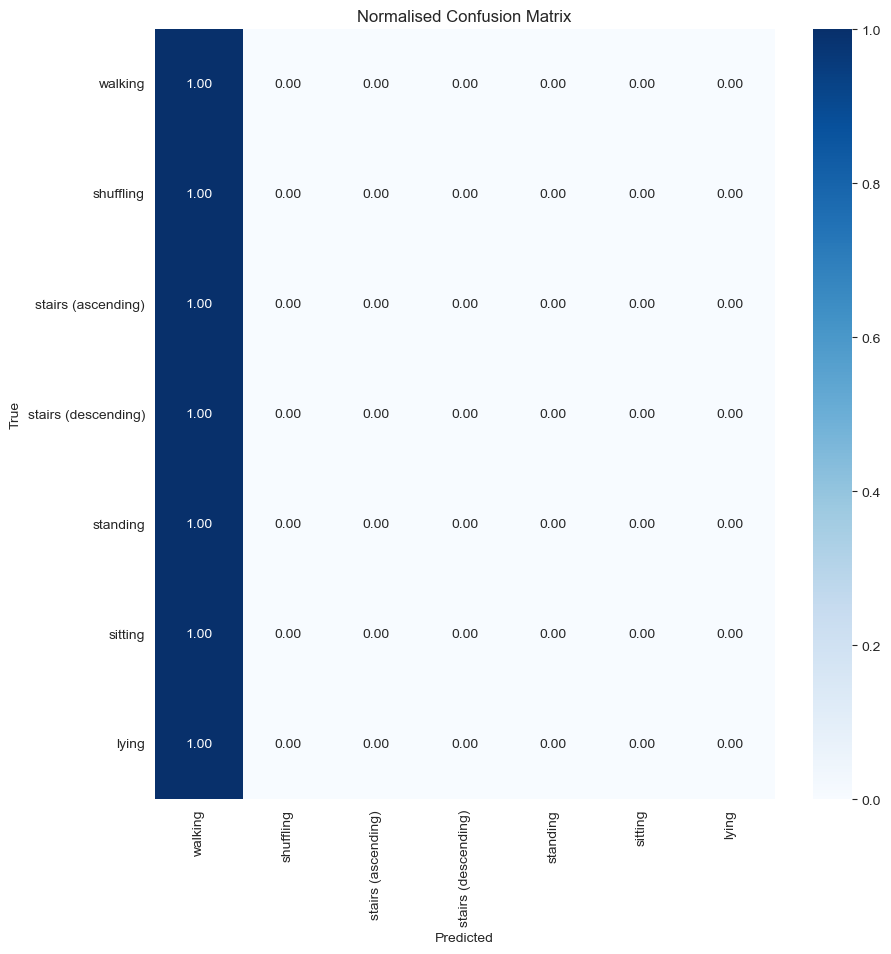

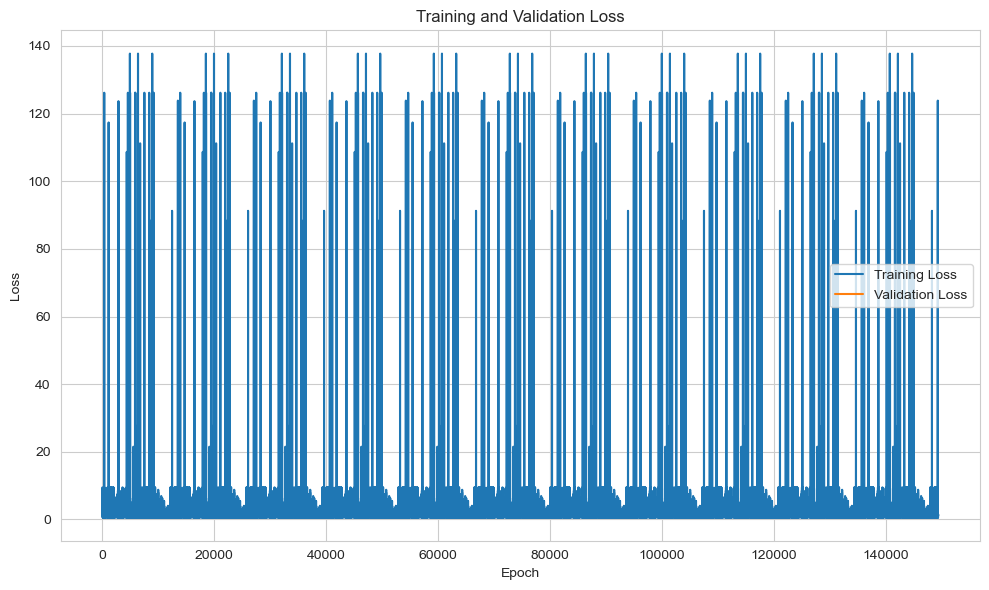

In [23]:
# Now we will try the hierarchyESN with a readout of Linear -> Activation -> Softmax

hierarchyESN_las_pickle = 'hierarchyESN_har70_variableReadout_las.pkl'

las_readout = nn.Sequential(
    nn.Linear(hierarchy_n_neurons_2 + hierarchy_n_neurons_1, y_train_encoded.shape[1], device='cuda'),
    nn.ReLU(),
    nn.Softmax(dim=1)
)

hierarchy_esn = fit_hierarchical_model(las_readout, hierarchyESN_las_pickle, run_hierarchy_LAS)

nrmse_hierarchy_las, losses_hierarchy_las, val_losses_hierarchy_las = test_model(hierarchy_esn, 'Hierarchy ESN LAS')

In [24]:
run_hierarchy_LALS = False

100%|██████████| 562547/562547 [05:52<00:00, 1597.00it/s]


Shape of previous_states: torch.Size([562547, 500])
Hierarchy ESN LALS NRMSE: 0.47344365046177816


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.72      0.04      0.07    346581
           3       0.02      0.06      0.03     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.65      0.00       370
           6       0.57      0.12      0.20    141796
           7       0.44      1.00      0.61     43204
           8       0.00      0.00      0.00      8248

    accuracy                           0.13    562547
   macro avg       0.25      0.27      0.13    562547
weighted avg       0.62      0.13      0.14    562547



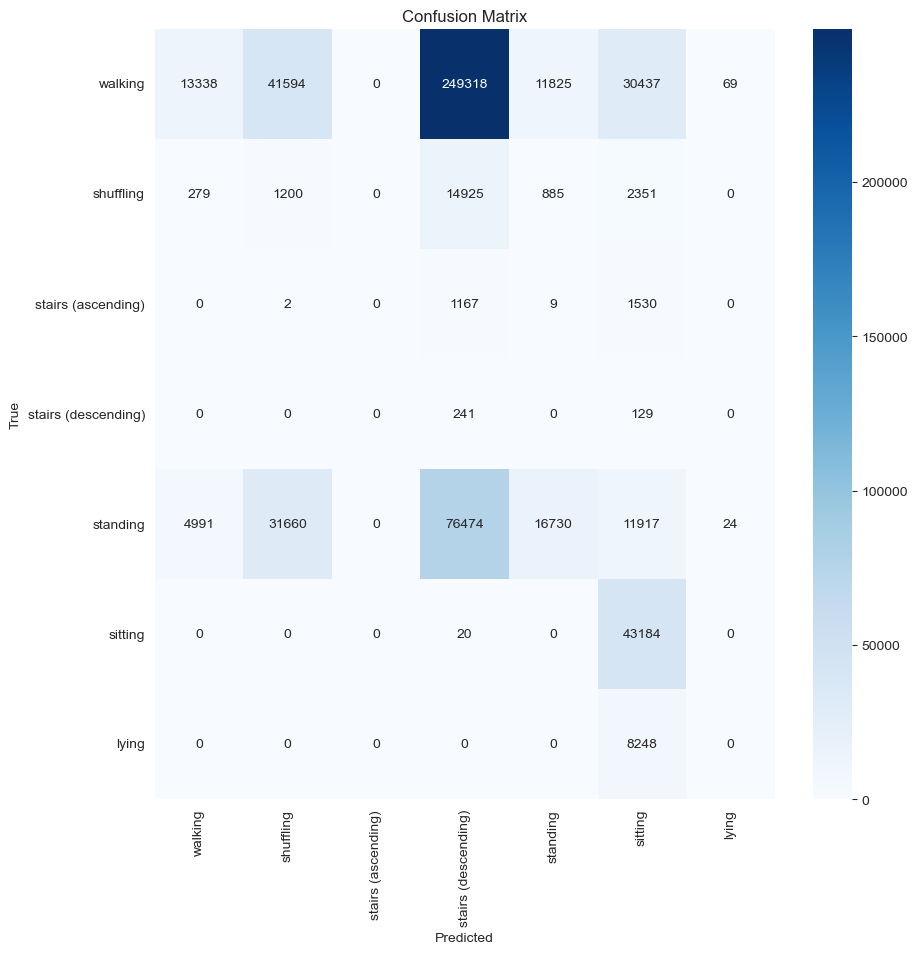

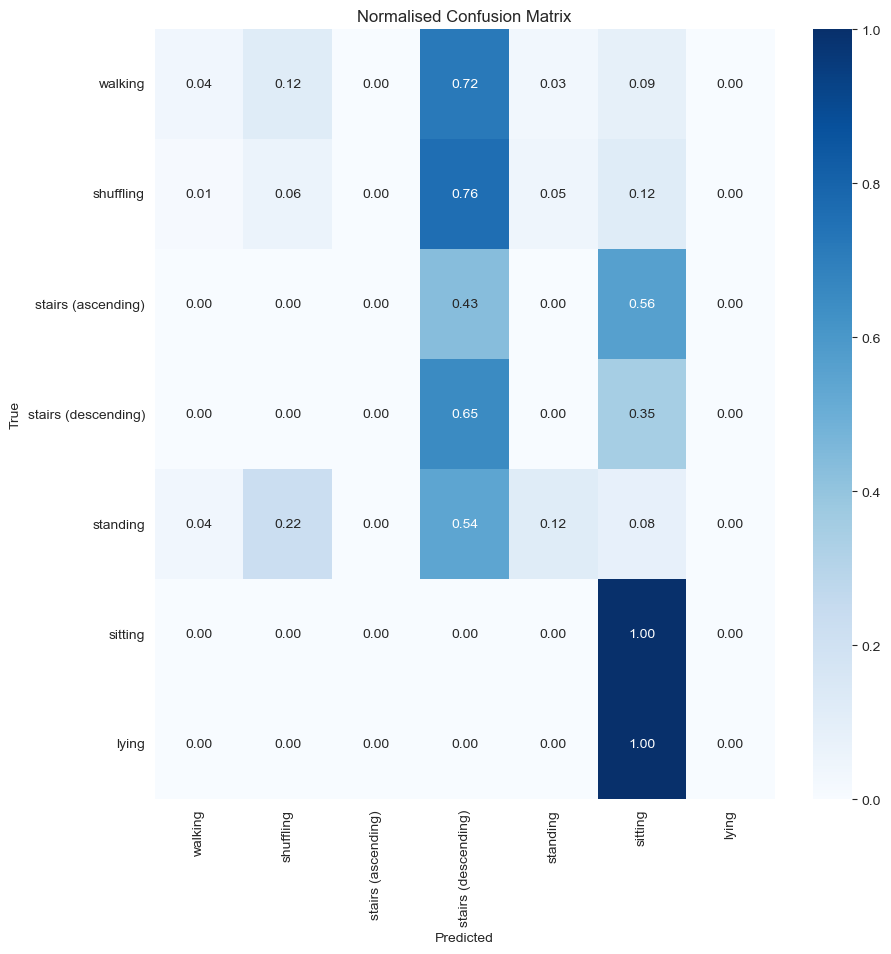

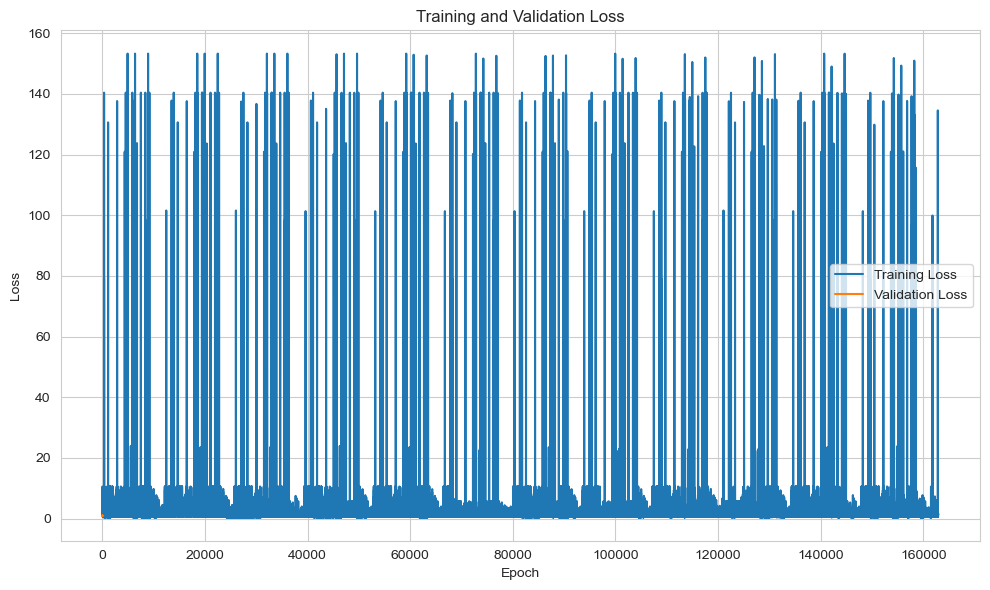

In [25]:
# Now we will try the hierarchyESN with a readout of Linear -> Activation -> Linear -> Softmax

hierarchyESN_lals_pickle = 'hierarchyESN_har70_variableReadout_lals.pkl'

lals_readout = nn.Sequential(
    nn.Linear(hierarchy_n_neurons_2 + hierarchy_n_neurons_1, n_neurons_output_midpoint, device='cuda'),
    nn.ReLU(),
    nn.Linear(n_neurons_output_midpoint, y_train_encoded.shape[1], device='cuda'),
    nn.Softmax(dim=1)
)

hierarchy_esn = fit_hierarchical_model(lals_readout, hierarchyESN_lals_pickle, run_hierarchy_LALS)

nrmse_hierarchy_lals, losses_hierarchy_lals, val_losses_hierarchy_lals = test_model(hierarchy_esn, 'Hierarchy ESN LALS')

In [26]:
run_hierarchy_LADLS = False

100%|██████████| 562547/562547 [05:51<00:00, 1602.58it/s]


Shape of previous_states: torch.Size([562547, 500])
Hierarchy ESN LADLS NRMSE: 0.4674609663553822


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.73      0.01      0.02    346581
           3       0.05      0.18      0.07     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.72      0.00       370
           6       0.38      0.49      0.43    141796
           7       0.99      0.99      0.99     43204
           8       0.98      0.99      0.98      8248

    accuracy                           0.23    562547
   macro avg       0.45      0.48      0.36    562547
weighted avg       0.64      0.23      0.21    562547



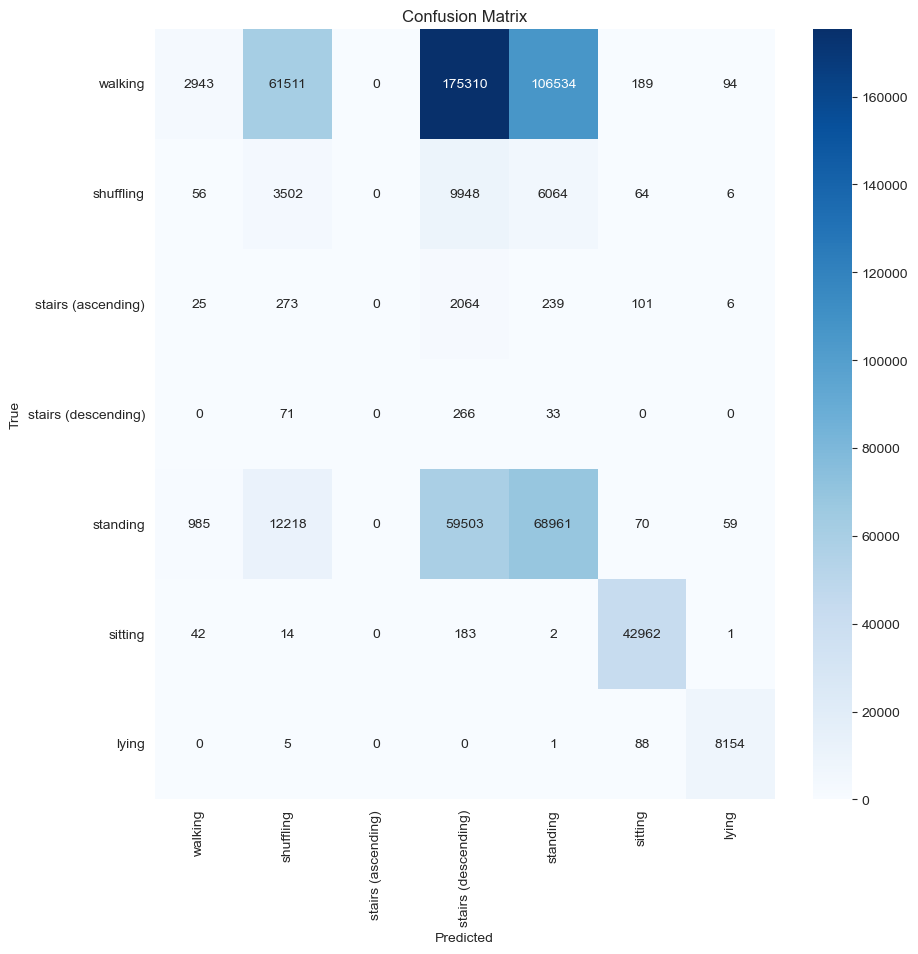

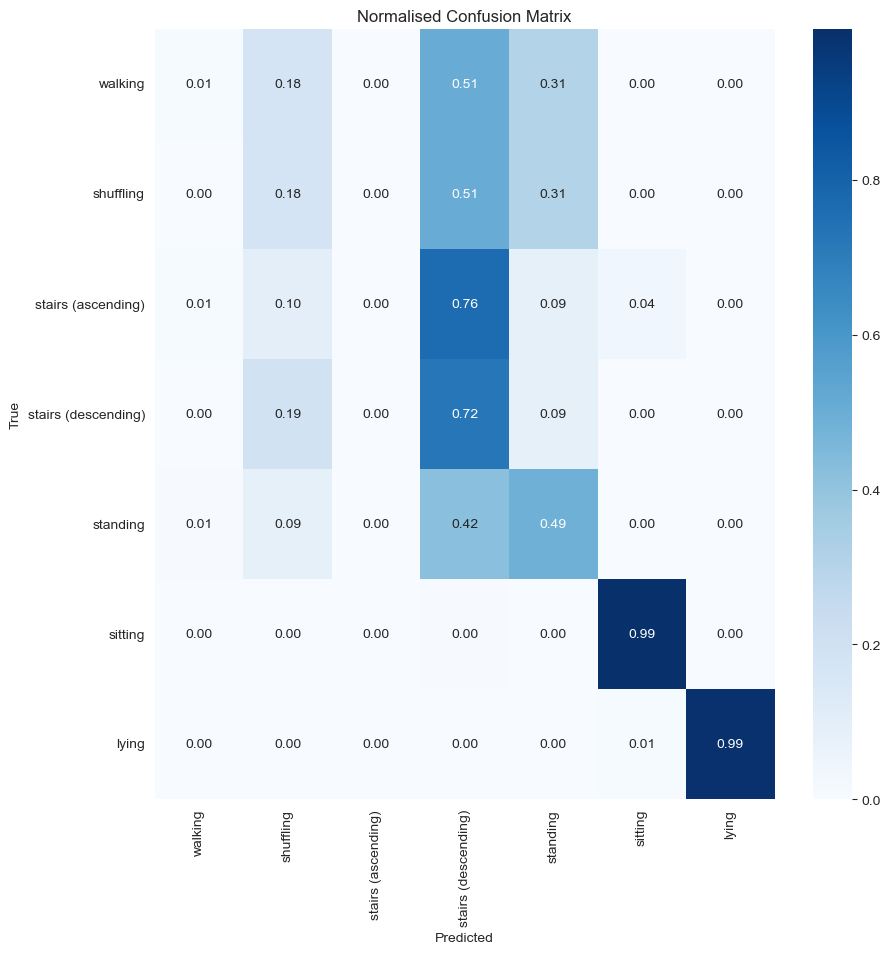

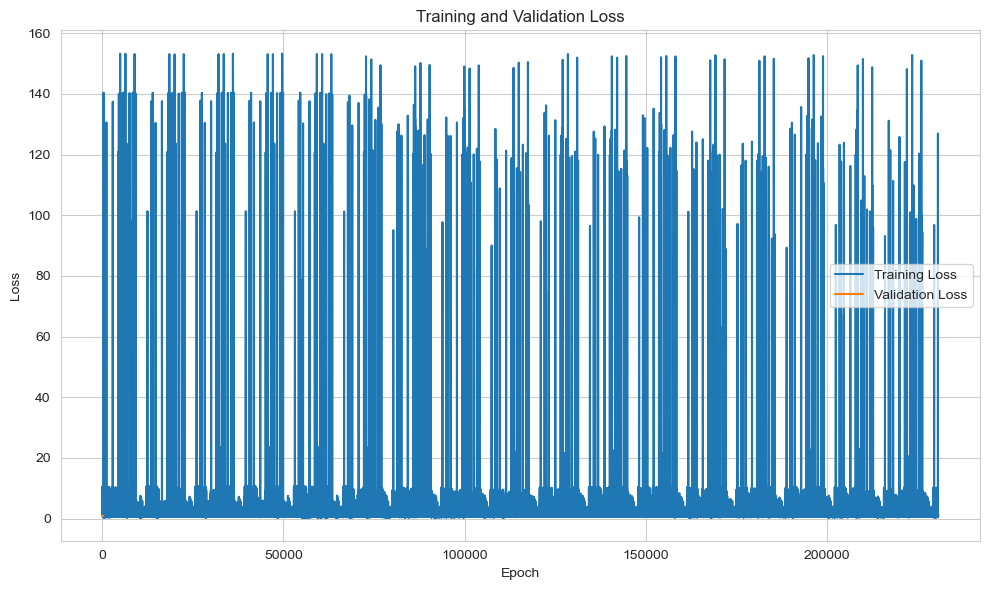

In [27]:
# Now we will try the hierarchyESN with a readout of Linear -> Activation -> Dropout -> Linear -> Softmax

hierarchyESN_ladls_pickle = 'hierarchyESN_har70_variableReadout_ladls.pkl'

l_adls_readout = nn.Sequential(
    nn.Linear(hierarchy_n_neurons_2 + hierarchy_n_neurons_1, n_neurons_output_midpoint, device='cuda'),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(n_neurons_output_midpoint, y_train_encoded.shape[1], device='cuda'),
    nn.Softmax(dim=1)
)

hierarchy_esn = fit_hierarchical_model(l_adls_readout, hierarchyESN_ladls_pickle, run_hierarchy_LADLS)

nrmse_hierarchy_ladls, losses_hierarchy_ladls, val_losses_hierarchy_ladls = test_model(hierarchy_esn, 'Hierarchy ESN LADLS')

In [28]:
run_threeHierarchy_LS = False

Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547
Step: 380000/562547
Step: 390000/562547
Step: 400000/562547
Step: 410000/562547
Step: 420000/562547
Step: 430000/562547
Step: 440000/562547
Step: 450000/562547
Step: 460000/562547
Step: 470000/562547
Step: 480000/562547
Step: 490000/562547
Step: 500000/5

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.72      0.00       370
           6       0.33      0.80      0.47    141796
           7       0.99      0.99      0.99     43204
           8       0.99      1.00      0.99      8248

    accuracy                           0.29    562547
   macro avg       0.33      0.50      0.35    562547
weighted avg       0.17      0.29      0.21    562547



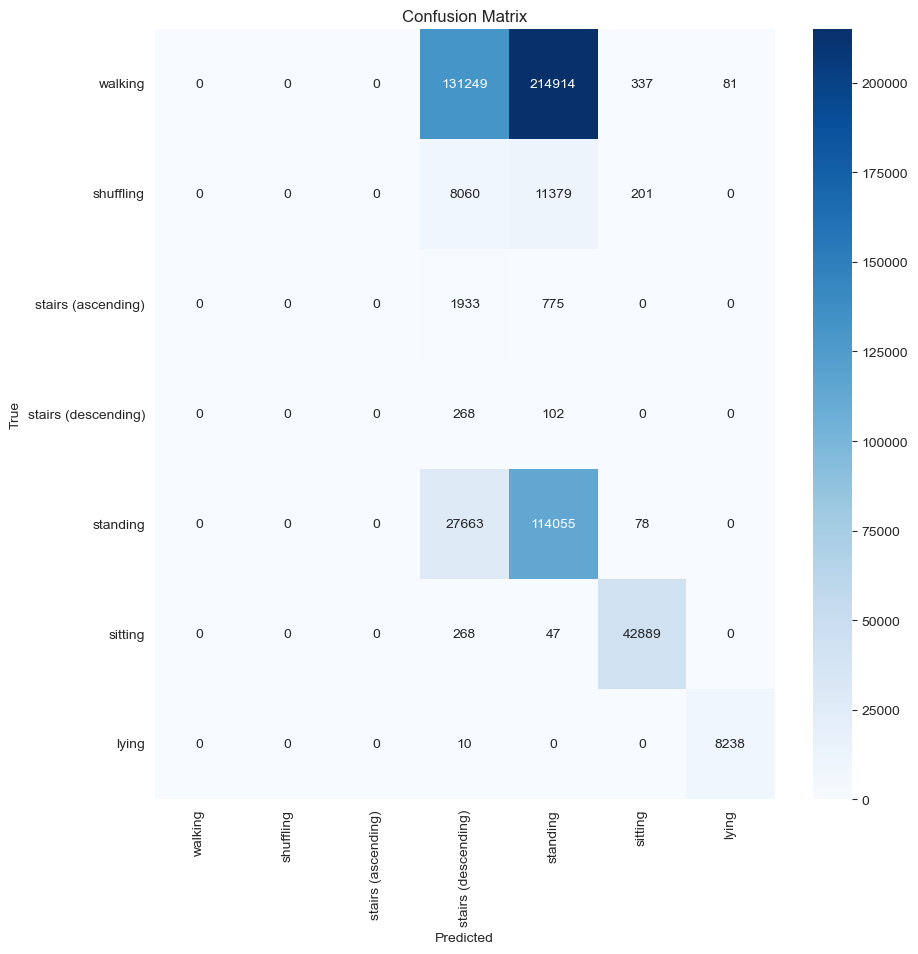

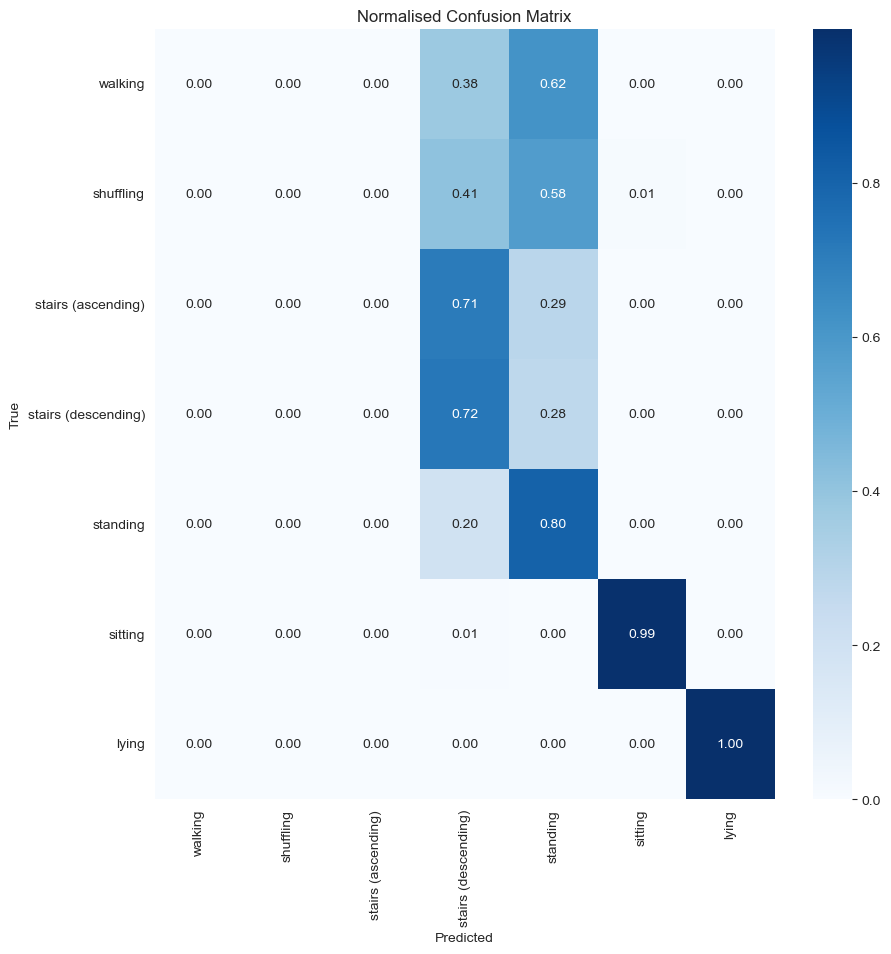

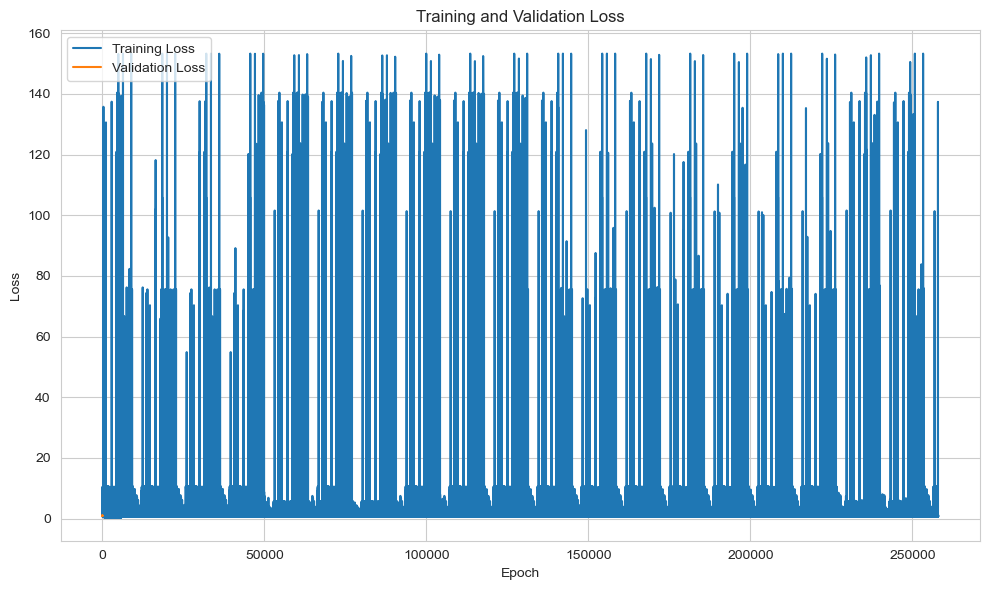

In [29]:
# First, the threeHierarchyESN with a readout of Linear -> Softmax

threeHierarchyESN_ls_pickle = 'threeHierarchyESN_har70_variableReadout_ls.pkl'

ls_readout = nn.Sequential(
    nn.Linear(threeh_n_neurons_3 + threeh_n_neurons_2 + threeh_n_neurons_1, y_train_encoded.shape[1], device='cuda'),
    nn.Softmax(dim=1)
)

three_hierarchy_esn = fit_three_hierarchical_model(ls_readout, threeHierarchyESN_ls_pickle, run_threeHierarchy_LS)

nrmse_threeHierarchy_ls, losses_threeHierarchy_ls, val_losses_threeHierarchy_ls = test_model(three_hierarchy_esn, 'Three Hierarchy ESN LS')


In [30]:
run_threeHierarchy_LAS = True

[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117


E:\PyCharm\COM6906-Dissertation\model\reservoir\ThreeHierarchyESNCudaVariableReadout.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device='cuda')


Step: 0/1357646
Step: 10000/1357646
Step: 20000/1357646
Step: 30000/1357646
Step: 40000/1357646
Step: 50000/1357646
Step: 60000/1357646
Step: 70000/1357646
Step: 80000/1357646
Step: 90000/1357646
Step: 100000/1357646
Step: 110000/1357646
Step: 120000/1357646
Step: 130000/1357646
Step: 140000/1357646
Step: 150000/1357646
Step: 160000/1357646
Step: 170000/1357646
Step: 180000/1357646
Step: 190000/1357646
Step: 200000/1357646
Step: 210000/1357646
Step: 220000/1357646
Step: 230000/1357646
Step: 240000/1357646
Step: 250000/1357646
Step: 260000/1357646
Step: 270000/1357646
Step: 280000/1357646
Step: 290000/1357646
Step: 300000/1357646
Step: 310000/1357646
Step: 320000/1357646
Step: 330000/1357646
Step: 340000/1357646
Step: 350000/1357646
Step: 360000/1357646
Step: 370000/1357646
Step: 380000/1357646
Step: 390000/1357646
Step: 400000/1357646
Step: 410000/1357646
Step: 420000/1357646
Step: 430000/1357646
Step: 440000/1357646
Step: 450000/1357646
Step: 460000/1357646
Step: 470000/1357646
Step: 

E:\PyCharm\COM6906-Dissertation\model\reservoir\ThreeHierarchyESNCudaVariableReadout.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device='cuda')


Step: 10000/339404
Step: 20000/339404
Step: 30000/339404
Step: 40000/339404
Step: 50000/339404
Step: 60000/339404
Step: 70000/339404
Step: 80000/339404
Step: 90000/339404
Step: 100000/339404
Step: 110000/339404
Step: 120000/339404
Step: 130000/339404
Step: 140000/339404
Step: 150000/339404
Step: 160000/339404
Step: 170000/339404
Step: 180000/339404
Step: 190000/339404
Step: 200000/339404
Step: 210000/339404
Step: 220000/339404
Step: 230000/339404
Step: 240000/339404
Step: 250000/339404
Step: 260000/339404
Step: 270000/339404
Step: 280000/339404
Step: 290000/339404
Step: 300000/339404
Step: 310000/339404
Step: 320000/339404
Step: 9404/339404
Shape of previous_states: torch.Size([339404, 500])


E:\PyCharm\COM6906-Dissertation\model\reservoir\ThreeHierarchyESNCudaVariableReadout.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_state = torch.tensor(val_state, dtype=torch.float32, device='cuda')


Epoch 1/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 2/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 3/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 4/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 5/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 6/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 7/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 8/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 9/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 10/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Epoch 11/100, Loss: 1.1711305379867554, Validation Loss: 0.9377732872962952
Early stopping after 10 epochs as loss has not improved in the last 10 epochs.
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.62      1.00      0.76    346581
           3       0.00      0.00      0.00     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.00      0.00      0.00    141796
           7       0.00      0.00      0.00     43204
           8       0.00      0.00      0.00      8248

    accuracy                           0.62    562547
   macro avg       0.09      0.14      0.11    562547
weighted avg       0.38      0.62      0.47    562547



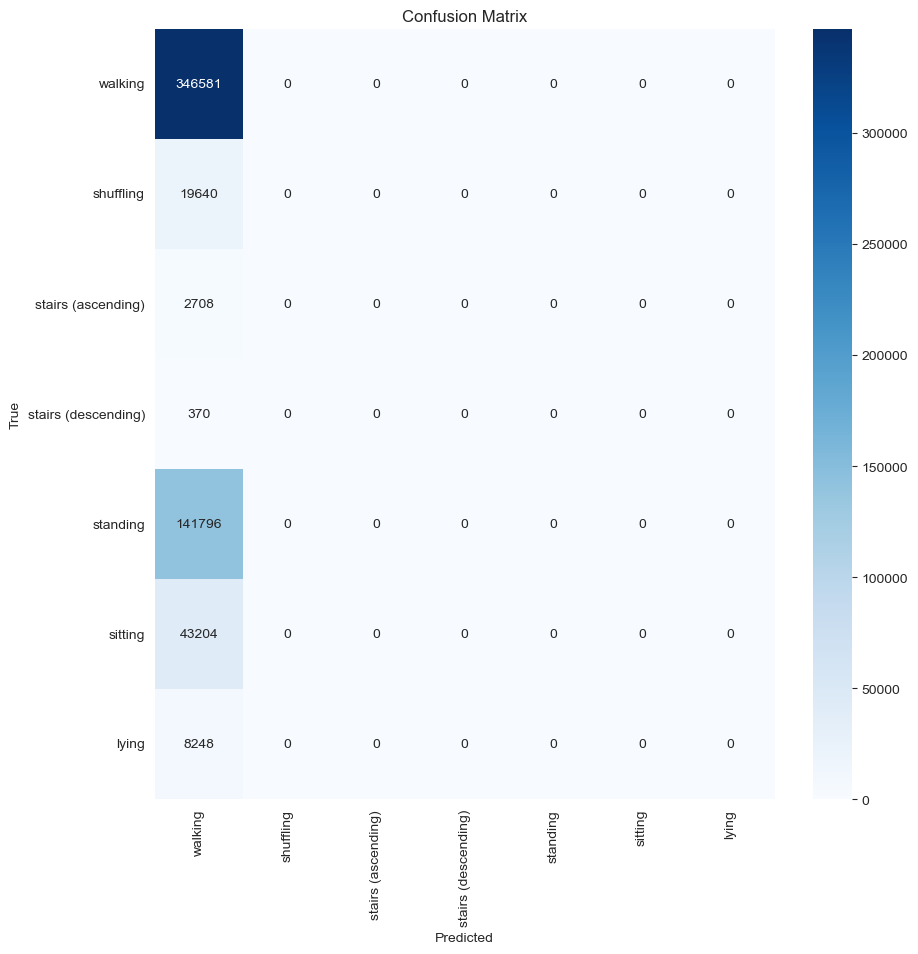

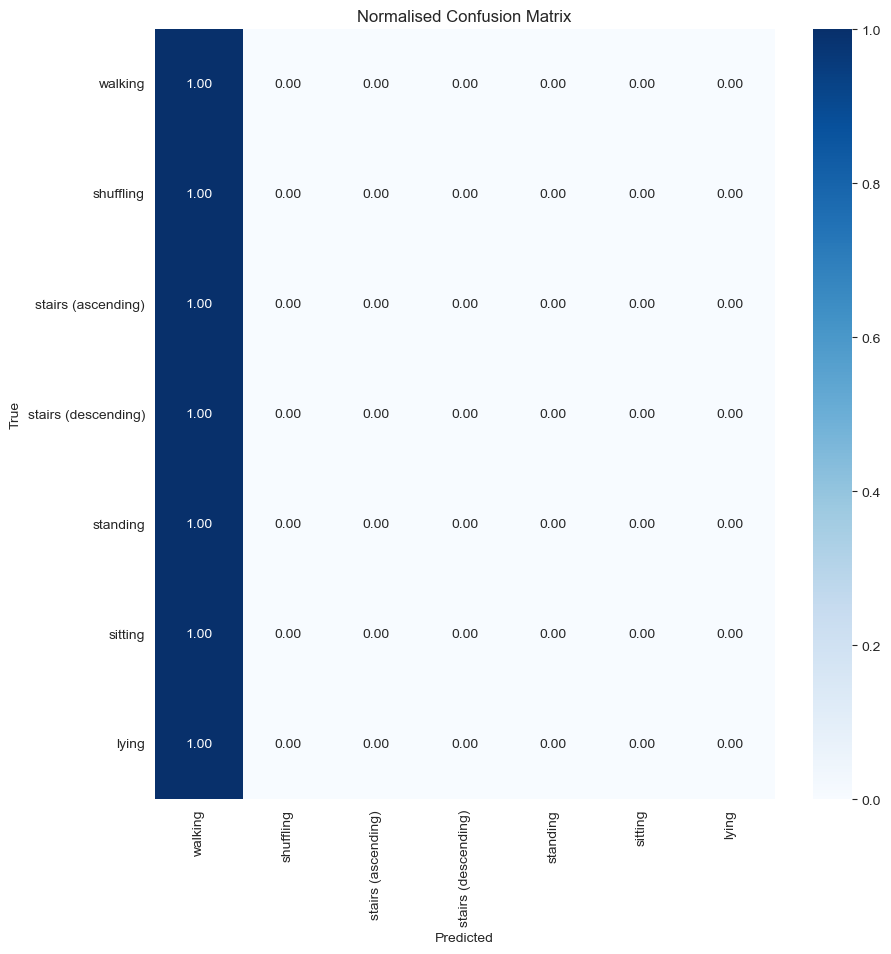

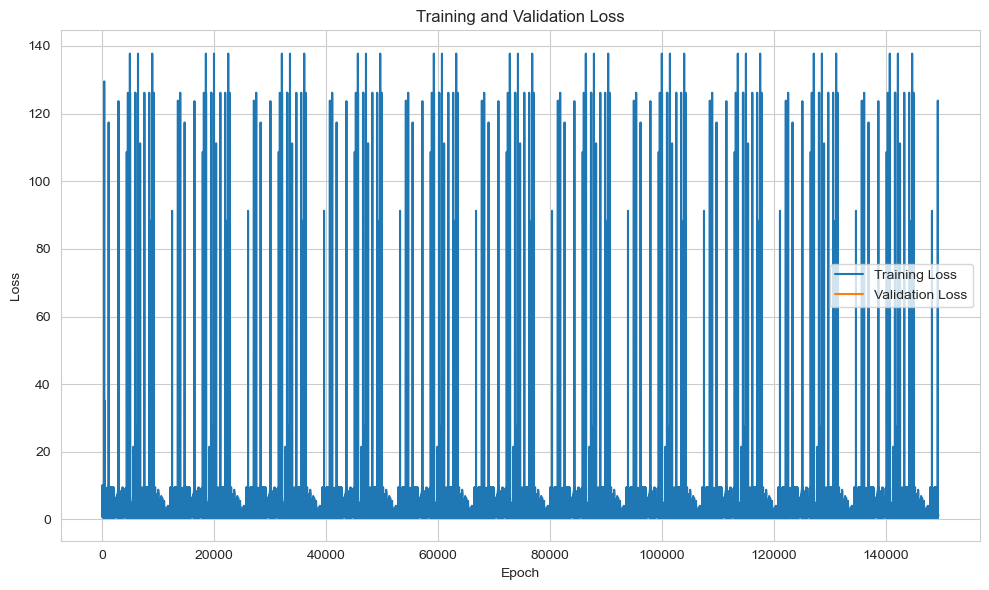

In [31]:
# Now we will try the threeHierarchyESN with a readout of Linear -> Activation -> Softmax

threeHierarchyESN_las_pickle = 'threeHierarchyESN_har70_variableReadout_las.pkl'

las_readout = nn.Sequential(
    nn.Linear(threeh_n_neurons_3 + threeh_n_neurons_2 + threeh_n_neurons_1, y_train_encoded.shape[1], device='cuda'),
    nn.ReLU(),
    nn.Softmax(dim=1)
)

three_hierarchy_esn = fit_three_hierarchical_model(las_readout, threeHierarchyESN_las_pickle, run_threeHierarchy_LAS)

nrmse_threeHierarchy_las, losses_threeHierarchy_las, val_losses_threeHierarchy_las = test_model(three_hierarchy_esn, 'Three Hierarchy ESN LAS')

In [32]:
run_threeHierarchy_LALS = True

[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/1357646


E:\PyCharm\COM6906-Dissertation\model\reservoir\ThreeHierarchyESNCudaVariableReadout.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device='cuda')


Step: 10000/1357646
Step: 20000/1357646
Step: 30000/1357646
Step: 40000/1357646
Step: 50000/1357646
Step: 60000/1357646
Step: 70000/1357646
Step: 80000/1357646
Step: 90000/1357646
Step: 100000/1357646
Step: 110000/1357646
Step: 120000/1357646
Step: 130000/1357646
Step: 140000/1357646
Step: 150000/1357646
Step: 160000/1357646
Step: 170000/1357646
Step: 180000/1357646
Step: 190000/1357646
Step: 200000/1357646
Step: 210000/1357646
Step: 220000/1357646
Step: 230000/1357646
Step: 240000/1357646
Step: 250000/1357646
Step: 260000/1357646
Step: 270000/1357646
Step: 280000/1357646
Step: 290000/1357646
Step: 300000/1357646
Step: 310000/1357646
Step: 320000/1357646
Step: 330000/1357646
Step: 340000/1357646
Step: 350000/1357646
Step: 360000/1357646
Step: 370000/1357646
Step: 380000/1357646
Step: 390000/1357646
Step: 400000/1357646
Step: 410000/1357646
Step: 420000/1357646
Step: 430000/1357646
Step: 440000/1357646
Step: 450000/1357646
Step: 460000/1357646
Step: 470000/1357646
Step: 480000/1357646
S

E:\PyCharm\COM6906-Dissertation\model\reservoir\ThreeHierarchyESNCudaVariableReadout.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device='cuda')


Step: 10000/339404
Step: 20000/339404
Step: 30000/339404
Step: 40000/339404
Step: 50000/339404
Step: 60000/339404
Step: 70000/339404
Step: 80000/339404
Step: 90000/339404
Step: 100000/339404
Step: 110000/339404
Step: 120000/339404
Step: 130000/339404
Step: 140000/339404
Step: 150000/339404
Step: 160000/339404
Step: 170000/339404
Step: 180000/339404
Step: 190000/339404
Step: 200000/339404
Step: 210000/339404
Step: 220000/339404
Step: 230000/339404
Step: 240000/339404
Step: 250000/339404
Step: 260000/339404
Step: 270000/339404
Step: 280000/339404
Step: 290000/339404
Step: 300000/339404
Step: 310000/339404
Step: 320000/339404
Step: 9404/339404
Shape of previous_states: torch.Size([339404, 500])


E:\PyCharm\COM6906-Dissertation\model\reservoir\ThreeHierarchyESNCudaVariableReadout.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_state = torch.tensor(val_state, dtype=torch.float32, device='cuda')


Epoch 1/100, Loss: 1.30323326587677, Validation Loss: 0.932477593421936
Epoch 2/100, Loss: 1.1953805685043335, Validation Loss: 0.8284672498703003
Epoch 3/100, Loss: 1.3023241758346558, Validation Loss: 0.9474859237670898
Epoch 4/100, Loss: 1.1955573558807373, Validation Loss: 0.8155924677848816
Epoch 5/100, Loss: 1.1955533027648926, Validation Loss: 0.8030531406402588
Epoch 6/100, Loss: 1.1690903902053833, Validation Loss: 0.7946438789367676
Epoch 7/100, Loss: 1.1829279661178589, Validation Loss: 0.8132926821708679
Epoch 8/100, Loss: 1.2751246690750122, Validation Loss: 1.0138369798660278
Epoch 9/100, Loss: 0.8090687990188599, Validation Loss: 0.8894594311714172
Epoch 10/100, Loss: 1.3032422065734863, Validation Loss: 1.0253727436065674
Epoch 11/100, Loss: 0.809068500995636, Validation Loss: 0.8894867897033691
Epoch 12/100, Loss: 1.1954737901687622, Validation Loss: 0.8098989725112915
Epoch 13/100, Loss: 0.8104395866394043, Validation Loss: 0.886086642742157
Epoch 14/100, Loss: 0.8142

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    346581
           3       0.03      0.04      0.03     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.00      0.00       370
           6       0.74      0.11      0.20    141796
           7       0.08      1.00      0.15     43204
           8       0.00      0.00      0.00      8248

    accuracy                           0.11    562547
   macro avg       0.12      0.16      0.05    562547
weighted avg       0.19      0.11      0.06    562547



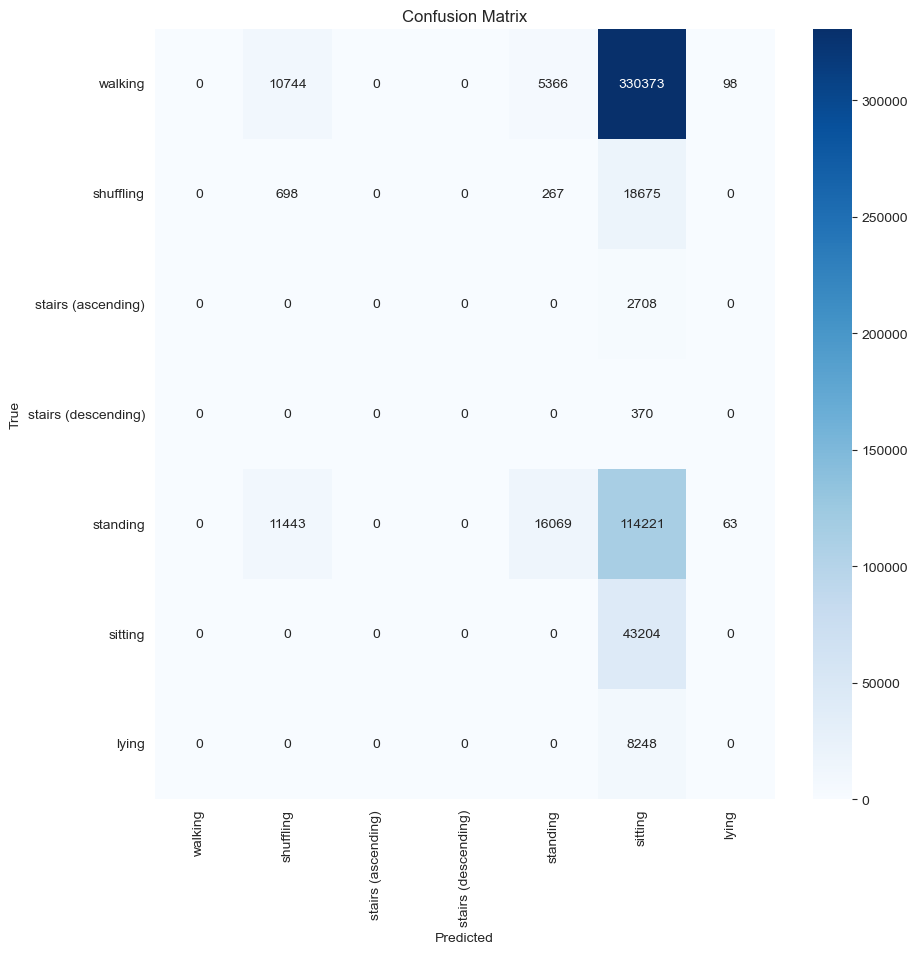

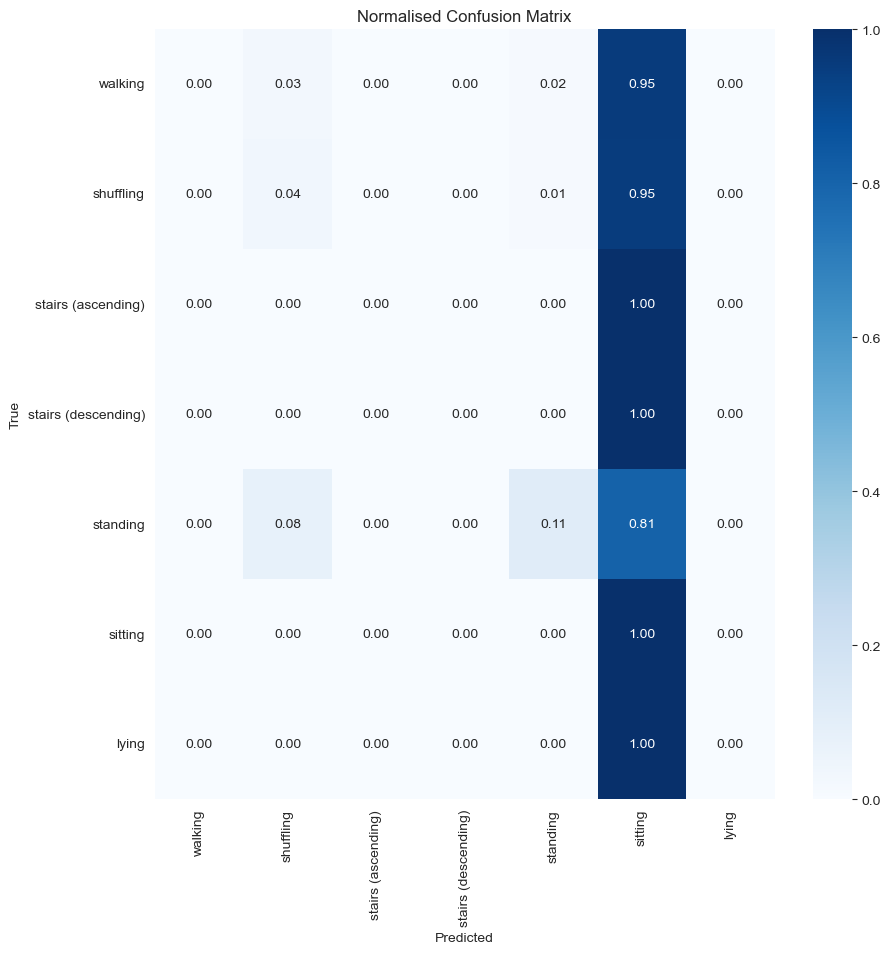

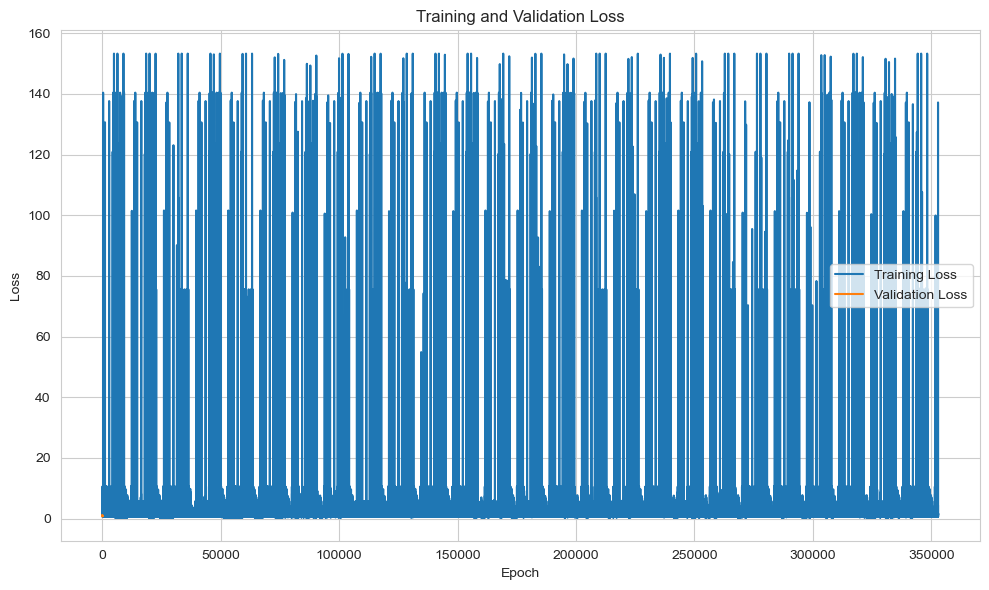

In [33]:
# Now we will try the threeHierarchyESN with a readout of Linear -> Activation -> Linear -> Softmax

threeHierarchyESN_lals_pickle = 'threeHierarchyESN_har70_variableReadout_lals.pkl'

lals_readout = nn.Sequential(
    nn.Linear(threeh_n_neurons_3 + threeh_n_neurons_2 + threeh_n_neurons_1, n_neurons_output_midpoint, device='cuda'),
    nn.ReLU(),
    nn.Linear(n_neurons_output_midpoint, y_train_encoded.shape[1], device='cuda'),
    nn.Softmax(dim=1)
)

three_hierarchy_esn = fit_three_hierarchical_model(lals_readout, threeHierarchyESN_lals_pickle, run_threeHierarchy_LALS)

nrmse_threeHierarchy_lals, losses_threeHierarchy_lals, val_losses_threeHierarchy_lals = test_model(three_hierarchy_esn, 'Three Hierarchy ESN LALS')

In [34]:
run_threeHierarchy_LADLS = True

[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117


E:\PyCharm\COM6906-Dissertation\model\reservoir\ThreeHierarchyESNCudaVariableReadout.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device='cuda')


Step: 0/1357646
Step: 10000/1357646
Step: 20000/1357646
Step: 30000/1357646
Step: 40000/1357646
Step: 50000/1357646
Step: 60000/1357646
Step: 70000/1357646
Step: 80000/1357646
Step: 90000/1357646
Step: 100000/1357646
Step: 110000/1357646
Step: 120000/1357646
Step: 130000/1357646
Step: 140000/1357646
Step: 150000/1357646
Step: 160000/1357646
Step: 170000/1357646
Step: 180000/1357646
Step: 190000/1357646
Step: 200000/1357646
Step: 210000/1357646
Step: 220000/1357646
Step: 230000/1357646
Step: 240000/1357646
Step: 250000/1357646
Step: 260000/1357646
Step: 270000/1357646
Step: 280000/1357646
Step: 290000/1357646
Step: 300000/1357646
Step: 310000/1357646
Step: 320000/1357646
Step: 330000/1357646
Step: 340000/1357646
Step: 350000/1357646
Step: 360000/1357646
Step: 370000/1357646
Step: 380000/1357646
Step: 390000/1357646
Step: 400000/1357646
Step: 410000/1357646
Step: 420000/1357646
Step: 430000/1357646
Step: 440000/1357646
Step: 450000/1357646
Step: 460000/1357646
Step: 470000/1357646
Step: 

E:\PyCharm\COM6906-Dissertation\model\reservoir\ThreeHierarchyESNCudaVariableReadout.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device='cuda')


Step: 10000/339404
Step: 20000/339404
Step: 30000/339404
Step: 40000/339404
Step: 50000/339404
Step: 60000/339404
Step: 70000/339404
Step: 80000/339404
Step: 90000/339404
Step: 100000/339404
Step: 110000/339404
Step: 120000/339404
Step: 130000/339404
Step: 140000/339404
Step: 150000/339404
Step: 160000/339404
Step: 170000/339404
Step: 180000/339404
Step: 190000/339404
Step: 200000/339404
Step: 210000/339404
Step: 220000/339404
Step: 230000/339404
Step: 240000/339404
Step: 250000/339404
Step: 260000/339404
Step: 270000/339404
Step: 280000/339404
Step: 290000/339404
Step: 300000/339404
Step: 310000/339404
Step: 320000/339404
Step: 9404/339404
Shape of previous_states: torch.Size([339404, 500])


E:\PyCharm\COM6906-Dissertation\model\reservoir\ThreeHierarchyESNCudaVariableReadout.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_state = torch.tensor(val_state, dtype=torch.float32, device='cuda')


Epoch 1/100, Loss: 0.8276139497756958, Validation Loss: 0.8912389874458313
Epoch 2/100, Loss: 1.154761791229248, Validation Loss: 0.9007581472396851
Epoch 3/100, Loss: 0.9029168486595154, Validation Loss: 0.8946401476860046
Epoch 4/100, Loss: 1.0226191282272339, Validation Loss: 0.8856140971183777
Epoch 5/100, Loss: 1.0508637428283691, Validation Loss: 0.8616830110549927
Epoch 6/100, Loss: 0.9753724336624146, Validation Loss: 0.8893680572509766
Epoch 7/100, Loss: 1.0733721256256104, Validation Loss: 0.8748549818992615
Epoch 8/100, Loss: 1.220328688621521, Validation Loss: 0.8895278573036194
Epoch 9/100, Loss: 1.1686580181121826, Validation Loss: 0.9212170839309692
Epoch 10/100, Loss: 1.162091612815857, Validation Loss: 0.9163095355033875
Epoch 11/100, Loss: 1.2326573133468628, Validation Loss: 0.9334740042686462
Epoch 12/100, Loss: 1.0160266160964966, Validation Loss: 0.9135560393333435
Epoch 13/100, Loss: 1.2472714185714722, Validation Loss: 0.9370359778404236
Epoch 14/100, Loss: 1.06

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.00      0.00    346581
           3       0.04      0.36      0.08     19640
           4       0.00      0.00      0.00      2708
           5       0.00      0.48      0.00       370
           6       0.39      0.41      0.40    141796
           7       0.91      0.94      0.92     43204
           8       0.90      0.63      0.75      8248

    accuracy                           0.20    562547
   macro avg       0.42      0.40      0.31    562547
weighted avg       0.60      0.20      0.19    562547



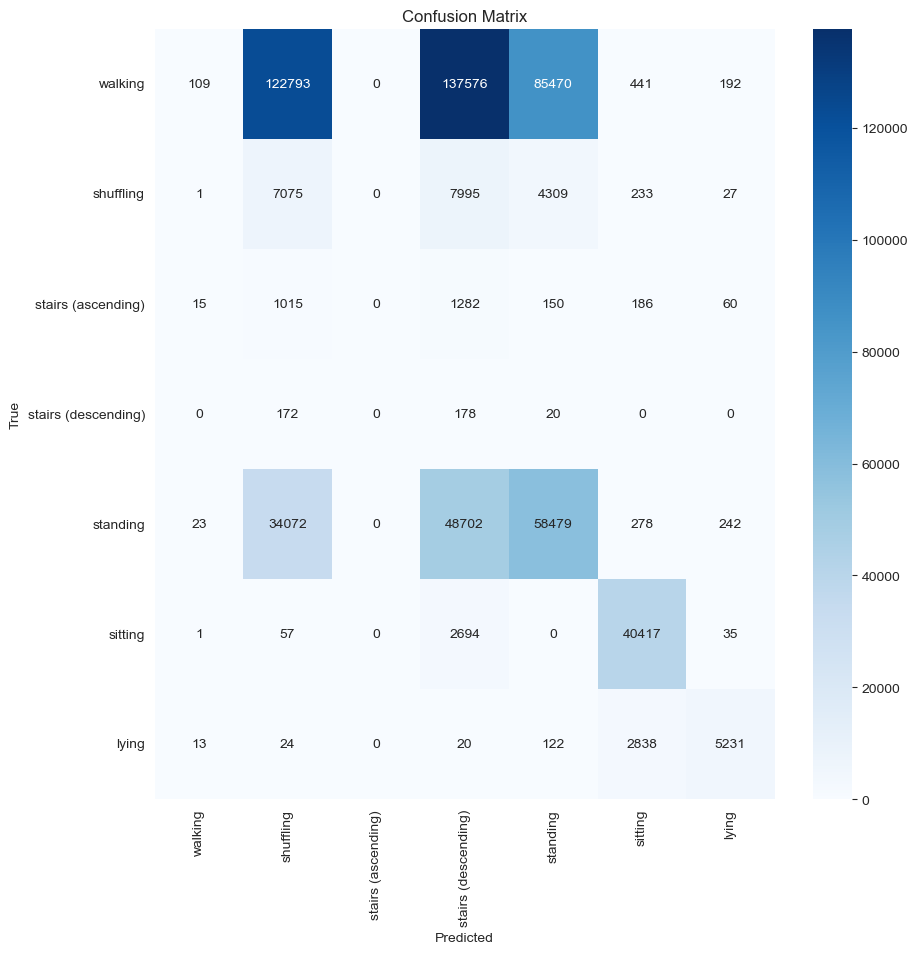

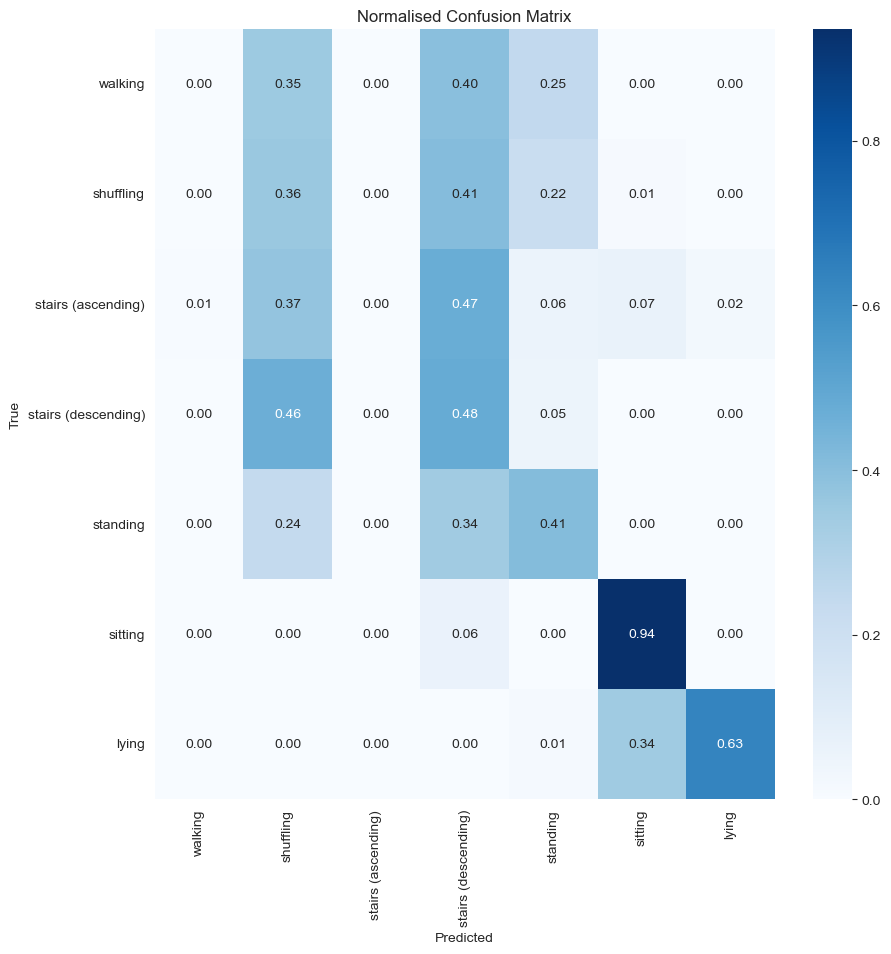

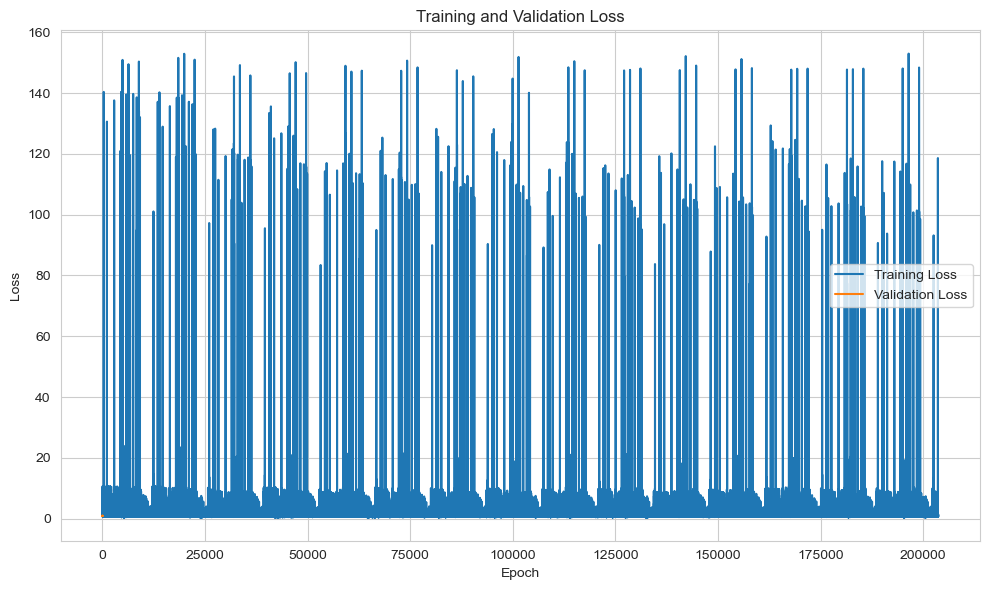

In [35]:
# Now we will try the threeHierarchyESN with a readout of Linear -> Activation -> Dropout -> Linear -> Softmax

threeHierarchyESN_ladls_pickle = 'threeHierarchyESN_har70_variableReadout_ladls.pkl'

l_adls_readout = nn.Sequential(
    nn.Linear(threeh_n_neurons_3 + threeh_n_neurons_2 + threeh_n_neurons_1, n_neurons_output_midpoint, device='cuda'),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(n_neurons_output_midpoint, y_train_encoded.shape[1], device='cuda'),
    nn.Softmax(dim=1)
)

three_hierarchy_esn = fit_three_hierarchical_model(l_adls_readout, threeHierarchyESN_ladls_pickle, run_threeHierarchy_LADLS)

nrmse_threeHierarchy_ladls, losses_threeHierarchy_ladls, val_losses_threeHierarchy_ladls = test_model(three_hierarchy_esn, 'Three Hierarchy ESN LADLS')